In [3]:
from datetime import datetime
from fuzzywuzzy import process, fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import re
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import warnings
warnings.simplefilter('ignore')
import matplotlib.patches as mpatches


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
#Defining function that returns the share of the categories in a single column
def get_shares_single_col_df(df, col):
    '''
    Input: a dataframe and a column name in the df
    For that column in the df, calculate the share of unique values
    Output: a new dataframe containg the unique value names and their share 
    '''
    df_new = df[col].value_counts().to_frame().reset_index()
    df_new.columns = ['cat', 'count']
    df_new['share'] = df_new['count']/df_new['count'].sum()
    return df_new

## Datasets

### Dynamic dataset (clicks)

Load the fact state info dataset.

In [4]:
fact_state_info = pd.read_csv("fact_state_info.csv")
fact_state_info = fact_state_info[['ip_address', 'interaction_id', 'ts', 'state_id',
       'page_url_clean', 'page_referrer', 'cart',  'fingerprint']].drop_duplicates()


In [5]:
fact_state_info.head(3)

,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,cart,fingerprint
0,1.120.226.109,536ce52c-3e19-4b25-b212-df6fcbfb2de6,2022-03-23 10:37:17.853000+00:00,536ce52c-3e19-4b25-b212-df6fcbfb2de6,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet?__cf_chl_tk=IsZFHLE_LqstSJj8mDWYtrGiBd0L.eLb1qGSdqMLCck-1648031831-0-gaNycGzNCCU,[],3400670436
1,1.120.226.109,536ce52c-3e19-4b25-b212-df6fcbfb2de6,2022-03-23 10:37:17.857000+00:00,fb63d5f3-4364-4288-b028-76a13468b685,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet?__cf_chl_tk=IsZFHLE_LqstSJj8mDWYtrGiBd0L.eLb1qGSdqMLCck-1648031831-0-gaNycGzNCCU,[],3400670436
2,1.120.226.109,536ce52c-3e19-4b25-b212-df6fcbfb2de6,2022-03-23 10:37:18.196000+00:00,2e47ee93-2811-4487-834d-9a67ebd79831,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet?__cf_chl_tk=IsZFHLE_LqstSJj8mDWYtrGiBd0L.eLb1qGSdqMLCck-1648031831-0-gaNycGzNCCU,[],3400670436


We create a new column with the start_ts of an interaction that repeats down an interaction id: (For merging with other dataset)

In [6]:
start_ts_flag = fact_state_info[['interaction_id', 'state_id']].groupby('interaction_id').head(1)
start_ts_flag_list = start_ts_flag['state_id'].to_list()
fact_state_info['flag_start_ts']=np.where(fact_state_info['state_id'].isin(start_ts_flag_list), 1, 0)

fact_state_info['start_ts'] = np.where(fact_state_info['flag_start_ts']==1, fact_state_info['ts'], np.nan)
fact_state_info['start_ts'] = fact_state_info.groupby(['interaction_id'])['start_ts'].ffill()


In [7]:
print("The length of the dataset is: " + str(len(fact_state_info)) + " observations")
print("The dataset contains: " + str(fact_state_info.interaction_id.nunique()) + " unique sessions")

The length of the dataset is: 3414688 observations
The dataset contains: 404918 unique sessions


In [8]:
fact_state_info.head(3)

,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,cart,fingerprint,flag_start_ts,start_ts
0,1.120.226.109,536ce52c-3e19-4b25-b212-df6fcbfb2de6,2022-03-23 10:37:17.853000+00:00,536ce52c-3e19-4b25-b212-df6fcbfb2de6,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet?__cf_chl_tk=IsZFHLE_LqstSJj8mDWYtrGiBd0L.eLb1qGSdqMLCck-1648031831-0-gaNycGzNCCU,[],3400670436,1,2022-03-23 10:37:17.853000+00:00
1,1.120.226.109,536ce52c-3e19-4b25-b212-df6fcbfb2de6,2022-03-23 10:37:17.857000+00:00,fb63d5f3-4364-4288-b028-76a13468b685,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet?__cf_chl_tk=IsZFHLE_LqstSJj8mDWYtrGiBd0L.eLb1qGSdqMLCck-1648031831-0-gaNycGzNCCU,[],3400670436,0,2022-03-23 10:37:17.853000+00:00
2,1.120.226.109,536ce52c-3e19-4b25-b212-df6fcbfb2de6,2022-03-23 10:37:18.196000+00:00,2e47ee93-2811-4487-834d-9a67ebd79831,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet,https://www.leisureoutlet.com/outdoor-pursuits/cycling-clothing/gilets/169101-etc-arid-unisex-reflective-cycling-gilet?__cf_chl_tk=IsZFHLE_LqstSJj8mDWYtrGiBd0L.eLb1qGSdqMLCck-1648031831-0-gaNycGzNCCU,[],3400670436,0,2022-03-23 10:37:17.853000+00:00


### Static dataset

Load the fact interaction info dataset and remove sessions that finish after the timeframe of the previous dataset.

In [9]:
# Some interactions remain idle for more than 30 min but less than 1 hour, so they appear twice => keep the  interaction that comes first
fact_interaction_info = pd.read_csv("fact_interaction_info.csv")

fact_interaction_info = fact_interaction_info[['interaction_id', 'start_ts','end_ts', 
'device_name', 'agent_name','useragent', 'referring_url', 'profile_email',
'country_iso_code','latitude', 'longitude']][fact_interaction_info['end_ts'].str.contains('2022-04') == False]


In [10]:
print("The length of the dataset is: " + str(len(fact_interaction_info)) + " observations")
print("The dataset contains: " + str(fact_interaction_info.interaction_id.nunique()) + " unique sessions")

The length of the dataset is: 400853 observations
The dataset contains: 400450 unique sessions


That implies that some interaction ids repeat. Let's inspect that:

In [11]:
fact_interaction_info['interactions_count']  = fact_interaction_info.groupby(['interaction_id'])['interaction_id'].transform('count')
fact_interaction_info['interactions_count'].value_counts()

1    400075
2    700   
3    66    
4    12    
Name: interactions_count, dtype: int64

In [12]:
fact_interaction_info.head(3)

,interaction_id,start_ts,end_ts,device_name,agent_name,useragent,referring_url,profile_email,country_iso_code,latitude,longitude,interactions_count
6,ae1077ee-0b08-4a8f-bd3b-9dcba1d1c76f,2022-03-25 07:45:36.799000+00:00,2022-03-25 07:48:14.324000+00:00,iPhone,Facebook,"Mozilla/5.0 (iPhone; CPU iPhone OS 15_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/19D52 [FBAN/FBIOS;FBAV/358.0.0.29.112;FBBV/357001037;FBDV/iPhone12,1;FBMD/iPhone;FBSN/iOS;FBSV/15.3.1;FBSS/2;FBID/phone;FBLC/en_GB;FBOP/5;FBRV/358995778]",https://l.facebook.com/,NaN,GB,53.3376,-1.4771,1
7,f0baea21-f22f-4af6-ab14-a504426a006d,2022-03-25 17:29:27.598000+00:00,2022-03-25 17:30:02.207000+00:00,iPhone,Facebook,"Mozilla/5.0 (iPhone; CPU iPhone OS 15_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/19D52 [FBAN/FBIOS;FBAV/358.0.0.29.112;FBBV/357001037;FBDV/iPhone12,1;FBMD/iPhone;FBSN/iOS;FBSV/15.3.1;FBSS/2;FBID/phone;FBLC/en_GB;FBOP/5;FBRV/359146762]",https://l.facebook.com/,NaN,GB,54.7046,-5.8771,1
8,d3589e60-c1bc-41aa-b8b1-2dbbcc38c0f6,2022-03-25 19:57:53.466000+00:00,2022-03-25 19:59:04.546000+00:00,iPhone,Facebook,"Mozilla/5.0 (iPhone; CPU iPhone OS 15_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/19D52 [FBAN/FBIOS;FBAV/358.0.0.29.112;FBBV/357001037;FBDV/iPhone12,1;FBMD/iPhone;FBSN/iOS;FBSV/15.3.1;FBSS/2;FBID/phone;FBLC/en_GB;FBOP/5;FBRV/359174520]",https://l.facebook.com/,NaN,GB,52.1951,-1.1321,1


Indeed, some interaction ids repeat 4 times. Interaction ids repeat if the user has been idle during an interaction for more than 30 mins but less than an hour. The way to treat that is by merging by 'interaction_id' and 'start_ts'.

### Merge datasets

In [13]:
df1 = pd.merge(fact_state_info, fact_interaction_info,  how='inner', on =['interaction_id','start_ts'])
df1 = df1.sort_values(['interaction_id','ts'],ascending=True)

print("The length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


The length of the dataset is: 3355803 observations
It contains: 399145 unique sessions
It contains: 2769 sessions that end in purchase
The conversion rate is: 0.694 %


If we merge based on ip_address as well:
The length of the dataset is: 2672056 observations
and it contains 397174 unique sessions
Same number of unique interactions, but different total values. Since the ip_address can change during a session if someone switches internet proviser I choose not to use ip_address to merge the datasets.

In [14]:
df1.columns

Index(['ip_address', 'interaction_id', 'ts', 'state_id', 'page_url_clean',
       'page_referrer', 'cart', 'fingerprint', 'flag_start_ts', 'start_ts',
       'end_ts', 'device_name', 'agent_name', 'useragent', 'referring_url',
       'profile_email', 'country_iso_code', 'latitude', 'longitude',
       'interactions_count'],
      dtype='object')

In [15]:
# drop unnecessary columns
df1 = df1.drop(['end_ts',  'interactions_count'], axis=1)  # 'start_ts',  

In [16]:
df1.head(3)

,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,cart,fingerprint,flag_start_ts,start_ts,device_name,agent_name,useragent,referring_url,profile_email,country_iso_code,latitude,longitude
1151809,40.77.190.77,000065ab-81c5-4ee3-b476-116924a0ad9f,2022-03-15 06:11:30.211000+00:00,000065ab-81c5-4ee3-b476-116924a0ad9f,https://www.leisureoutlet.com/tents/shelters-and-utilities/utility-and-toilet-tents/50967-outdoor-revolution-outhouse-xl-utility-tent,NaN,[],3650495405,1,2022-03-15 06:11:30.211000+00:00,Spider,BingPreview,"Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Mac OS X) AppleWebKit/537.51.1 (KHTML, like Gecko) Version/7.0 Mobile/11A465 Safari/9537.53 BingPreview/1.0b",NaN,NaN,US,41.8874,-87.6318
3114244,92.40.172.2,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,2022-03-08 19:55:48.252000+00:00,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,https://www.leisureoutlet.com/heating-and-cooking/biolite/off-grid-living-power/208038-biolite-campstove-2?surface=active,NaN,[],933636455,1,2022-03-08 19:55:48.252000+00:00,Samsung SM-G981B,Samsung Internet,"Mozilla/5.0 (Linux; Android 12; SAMSUNG SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/16.0 Chrome/92.0.4515.166 Mobile Safari/537.36",NaN,NaN,GB,51.4964,-0.1224
3114245,92.40.172.2,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,2022-03-08 19:55:48.409000+00:00,39073f7a-d290-413c-9bbd-b7476ef37871,https://www.leisureoutlet.com/heating-and-cooking/biolite/off-grid-living-power/208038-biolite-campstove-2?surface=active,NaN,[],933636455,0,2022-03-08 19:55:48.252000+00:00,Samsung SM-G981B,Samsung Internet,"Mozilla/5.0 (Linux; Android 12; SAMSUNG SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/16.0 Chrome/92.0.4515.166 Mobile Safari/537.36",NaN,NaN,GB,51.4964,-0.1224


### Fill Missing Values

In [17]:
#inspect the null values in the dataset
null_values = df1.isnull().sum()
null_values = null_values[null_values > 0]
null_values = null_values.to_frame()
null_values.rename(columns = {0:'null count'}, inplace = True)
null_values['null percentage % '] = round((null_values['null count']/len(df1))*100,1)
null_values

,null count,null percentage %
page_url_clean,69,0.0
page_referrer,532389,15.9
referring_url,931296,27.8
profile_email,3038130,90.5
country_iso_code,207,0.0


In [18]:
df1[['country_iso_code', 'latitude', 'longitude']][df1['country_iso_code'].isnull() ==True].drop_duplicates()

,country_iso_code,latitude,longitude
1371819,NaN,35.0000,105.0000
175919,NaN,47.0000,8.0000
1173965,NaN,-22.5674,17.0849


In [19]:
# Check whether other observations in the dataset with those latitude-longitude combinations have the country_iso_code
print(df1[(df1['latitude']==35.0) & (df1['longitude']==105.0)]['country_iso_code'].unique())
print(df1[(df1['latitude']==47.0) & (df1['longitude']==8.0)]['country_iso_code'].unique())
print(df1[(df1['latitude']==-22.5674) & (df1['longitude']==17.0849)].head()['country_iso_code'].unique())

[nan]
[nan]
[nan]


Since it is only three latitude longitude combinations that we are missing and cannot be found from other observations in the dataset, we are searching them manually on https://www.latlong.net/Show-Latitude-Longitude.html

In [20]:
# Fill in the missing values in the country_iso_code
df1['country_iso_code'] = np.where((df1['latitude']==35.0) & (df1['longitude']==105.0), 'China', df1['country_iso_code'])
df1['country_iso_code'] = np.where((df1['latitude']==47.0) & (df1['longitude']==8.0), 'Switzerland', df1['country_iso_code'])
df1['country_iso_code'] = np.where((df1['latitude']==-22.5674) & (df1['longitude']==17.0849), 'Africa', df1['country_iso_code'])

In [21]:
#Fill the profile name and page referrer with Unknown if it is null
df1['profile_email'] = df1['profile_email'].fillna('Unknown')
df1['referring_url'] = df1['referring_url'].fillna('Unknown')



In [22]:
#Change the ts type
df1['ts']= pd.to_datetime(df1['ts'])

## Create Page Level Dataset

### Remove pages that were not requested by the user (i.e. .html and .ico)

In [23]:
# Filter out observations that end with 
df1 = df1[df1['page_url_clean'].str.contains('\.html|\.ico|\.aspx|\.gif|\.png|\.jpeg|\.jpg')==False]

In [24]:
print("The length of the page-level dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


The length of the page-level dataset is: 2682124 observations
It contains: 397385 unique sessions
It contains: 2769 sessions that end in purchase
The conversion rate is: 0.697 %


### Aggregate info to page-level dimension

To aggregate info to page-level dimension, first we need to index the webpage URLs within a session. However, note that since the dimension of df1 is click, when someone performs clicks within a webpage URL, that URL will repeat down a column. We want the URLs that repeat to have the same index. Therefore, we create a new df that has the webpage URLs when they are first requested, then we index that df (in order to flag each webpage URL request in a temporal order), and merge it with our original based on state_id (unique throughout df1). Last, we do ffill of the flag to fill in the NaNs and have consistency across webpage URL and webpage URL index.

Here we create the new df where the webpage URLs when they were first requested are kept. We create two new columns were we shift one position downwards the webpage URL as well as the interaction id within each interaction group. Then we create a third column that has binary value. More precisely, if the webpage URL matches the shifted webpage URL, and the interaction id matches the shifted interaction id, then the value is 0, and 1 otherwise. We do that to filter out the webpage URL that repeat within an interaction (i.e. we keep those rows with value 1).

In [25]:
df1 = df1.sort_values(['interaction_id','ts'],ascending=True)

In [26]:
# Create a new df with the necessary columns 
keep_first_URL_request = df1[['interaction_id', 'state_id', 'page_url_clean','ts']]


In [27]:
# Keep observations where a webpage URL is first requested
keep_first_URL_request['url_shift1'] =  keep_first_URL_request.groupby('interaction_id')['page_url_clean'].shift(1)
keep_first_URL_request['interaction_id_shift1'] = keep_first_URL_request.groupby('interaction_id')['interaction_id'].shift(1)
keep_first_URL_request['keep'] = np.where((keep_first_URL_request['page_url_clean'] == keep_first_URL_request['url_shift1']) & (keep_first_URL_request['interaction_id'] == keep_first_URL_request['interaction_id_shift1']),0,1)
keep_first_URL_request = keep_first_URL_request[keep_first_URL_request['keep'] ==1 ]
keep_first_URL_request['flag'] =  keep_first_URL_request.groupby(['interaction_id']).cumcount()+1
keep_first_URL_request.head(3)



,interaction_id,state_id,page_url_clean,ts,url_shift1,interaction_id_shift1,keep,flag
1151809,000065ab-81c5-4ee3-b476-116924a0ad9f,000065ab-81c5-4ee3-b476-116924a0ad9f,https://www.leisureoutlet.com/tents/shelters-and-utilities/utility-and-toilet-tents/50967-outdoor-revolution-outhouse-xl-utility-tent,2022-03-15 06:11:30.211000+00:00,NaN,NaN,1,1
3114244,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,https://www.leisureoutlet.com/heating-and-cooking/biolite/off-grid-living-power/208038-biolite-campstove-2?surface=active,2022-03-08 19:55:48.252000+00:00,NaN,NaN,1,1
3048208,0000a484-d41a-4728-a1a5-29ddc301f232,0000a484-d41a-4728-a1a5-29ddc301f232,https://www.leisureoutlet.com/awning-canopies/camper-van-awnings/awnings/204833-outdoor-revolution-cayman-sun-canopy-front-panel?surface=active,2022-03-18 19:58:04.324000+00:00,NaN,NaN,1,1


In [28]:
len(keep_first_URL_request)

740144

In [29]:
#Merge the flag with the original dataset
df1 = pd.merge(df1, keep_first_URL_request[['interaction_id', 'state_id', 'flag']],  how='left', left_on=['interaction_id','state_id'], right_on = ['interaction_id','state_id'])
df1['flag'] = df1['flag'].fillna(method="ffill")


In [30]:
#Replace '[]' with np.nan in the cart column to facilitate processing
df1['cart'] = np.where(df1['cart']=='[]', np.nan, df1['cart']) 


In [31]:
#Make info consistent across a webpage URL (note these are the attibutes of the click-level dataset)
col_names = ['page_referrer', 'cart']

for col_name in col_names:
    df1[col_name] = df1.groupby(['interaction_id','flag'])[col_name].ffill()
    df1[col_name] = df1.groupby(['interaction_id','flag'])[col_name].bfill()


df1['cart'] = df1.groupby(['interaction_id'])['cart'].ffill()  #upon further inspection e.g. interaction_id == 'a2cf0bb0-6c5b-4b2f-8cf1-d8ba49649044', it is required 


In [32]:
#Fill missing values
df1['cart'] = df1['cart'].fillna('[]')


In [33]:
df1.head(3)

,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,cart,fingerprint,flag_start_ts,start_ts,device_name,agent_name,useragent,referring_url,profile_email,country_iso_code,latitude,longitude,flag
0,40.77.190.77,000065ab-81c5-4ee3-b476-116924a0ad9f,2022-03-15 06:11:30.211000+00:00,000065ab-81c5-4ee3-b476-116924a0ad9f,https://www.leisureoutlet.com/tents/shelters-and-utilities/utility-and-toilet-tents/50967-outdoor-revolution-outhouse-xl-utility-tent,NaN,[],3650495405,1,2022-03-15 06:11:30.211000+00:00,Spider,BingPreview,"Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Mac OS X) AppleWebKit/537.51.1 (KHTML, like Gecko) Version/7.0 Mobile/11A465 Safari/9537.53 BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0
1,92.40.172.2,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,2022-03-08 19:55:48.252000+00:00,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,https://www.leisureoutlet.com/heating-and-cooking/biolite/off-grid-living-power/208038-biolite-campstove-2?surface=active,NaN,[],933636455,1,2022-03-08 19:55:48.252000+00:00,Samsung SM-G981B,Samsung Internet,"Mozilla/5.0 (Linux; Android 12; SAMSUNG SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/16.0 Chrome/92.0.4515.166 Mobile Safari/537.36",Unknown,Unknown,GB,51.4964,-0.1224,1.0
2,92.40.172.2,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,2022-03-08 19:55:48.409000+00:00,39073f7a-d290-413c-9bbd-b7476ef37871,https://www.leisureoutlet.com/heating-and-cooking/biolite/off-grid-living-power/208038-biolite-campstove-2?surface=active,NaN,[],933636455,0,2022-03-08 19:55:48.252000+00:00,Samsung SM-G981B,Samsung Internet,"Mozilla/5.0 (Linux; Android 12; SAMSUNG SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/16.0 Chrome/92.0.4515.166 Mobile Safari/537.36",Unknown,Unknown,GB,51.4964,-0.1224,1.0


In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2682124 entries, 0 to 2682123
Data columns (total 19 columns):
 #   Column            Dtype              
---  ------            -----              
 0   ip_address        object             
 1   interaction_id    object             
 2   ts                datetime64[ns, UTC]
 3   state_id          object             
 4   page_url_clean    object             
 5   page_referrer     object             
 6   cart              object             
 7   fingerprint       int64              
 8   flag_start_ts     int64              
 9   start_ts          object             
 10  device_name       object             
 11  agent_name        object             
 12  useragent         object             
 13  referring_url     object             
 14  profile_email     object             
 15  country_iso_code  object             
 16  latitude          float64            
 17  longitude         float64            
 18  flag              floa

In [35]:
# Keep observations where a webpage URL is first requested PLUS the very last URL
df1['url_shift1'] = df1.groupby('interaction_id')['page_url_clean'].shift(1)
df1['interaction_id_shift1'] = df1.groupby('interaction_id')['interaction_id'].shift(1)
df1['keep'] = np.where((df1['page_url_clean'] == df1['url_shift1']) & (df1['interaction_id'] == df1['interaction_id_shift1']),0,1)
df1 = df1[(df1['keep'] ==1)]

#Drop columns no longer needed
df1 = df1.drop(['keep', 'url_shift1','interaction_id_shift1'], axis=1)

In [36]:
print("The length of the page-level dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


The length of the page-level dataset is: 740144 observations
It contains: 397385 unique sessions
It contains: 2769 sessions that end in purchase
The conversion rate is: 0.697 %


### Label pages based on their content

In [37]:
#Create a column that is 1 if the url is the home page
df1['home'] = np.where((df1['page_url_clean']=='https://www.leisureoutlet.com/') |
                              (df1['page_url_clean']=='https://www.leisureoutlet.com')|
                              (df1['page_url_clean']=='https://lo.verto.site/')|
                              (df1['page_url_clean']=='http://lo.verto.site/')|
                              df1['page_url_clean'].str.contains('https://www.leisureoutlet.com/\?'), 1, 0) 


In [38]:
#Create a column that is 1 if the url is a checkout related url, else 0
df1['checkout'] = np.where(df1['page_url_clean'].str.contains('checkout'), 1, 0)


We filter out the ones that are checkout because you need to 'register' in order to do a checkout (although it does not really matter in which category we place those urls because none of these are going to be used - as long as they belong in one of these two categories)

In [39]:
#Create a column that is 1 if the url is an administrative url, else 0
df1['registration'] = np.where((df1['checkout']==0) &
                                        (df1['page_url_clean'].str.contains('/forgotten-password|/sign-up|/signup|/sign-in|/register|/my-account|/track|/admin/|/warranty|reset-password')==True)
                                        ,1,0)


In [40]:
#Create a column that is 1 if the url is a basket related url, else 0
df1['cart_page'] = np.where((df1['page_url_clean']=='https://www.leisureoutlet.com/basket') |
                                (df1['page_url_clean']=='https://www.leisureoutlet.com/basket/') |
                                df1['page_url_clean'].str.contains('https://www.leisureoutlet.com/basket\?|lo.verto.site/basket'), 1, 0) 



In [41]:
#Create a column that is 1 if the url is a search related url
df1['search'] = np.where(df1['page_url_clean'].str.contains('https://www.leisureoutlet.com/search|https://lo.verto.site/search'), 1, 0)

In [42]:
# Create a function that detects if elements of a list are contained in urls
def get_url_content(string, urls_list):
    if any(substring in string for substring in urls_list):
        return 1
    else:
        return 0


In [43]:
#Create a column that is 1 if the url contains blog contant on outdoor activities (e.g. diy project ideas), else 0
advice_url = ['advice-centre', '-show-sign-up', 'diy-project', 'test-event', 'advicehub', 'how-to-guides-from-outwell',
            'the-advice-hub', 'news', 'corporate-social-responsibility', 'enhance-your-camping-experience','recycling-scheme']

df1['advice'] = np.where((df1['page_url_clean'].apply(lambda url: get_url_content(url,advice_url)) == 1) &
                              (df1['search']!= 1), 1, 0) 



In [44]:
#Create a column that is 1 if the url contains information on how Leisure Outlet operates, else 0
info_url = ['returns', 'terms-and-conditions','privacy-policy', 
           'about-us', 'contact-us', 'thank-you-for-your-enquiry','thank-you-for-your-request',
           'delivery-information', 'price-match', 'cookie-policy', 'live-chat', 'dial-a-deal-february-2022',
           'leisure-outlet-discount-codes', 'reserve-your-kids-bike-for-christmas', 'discounts-for-nhs-and-police-force-employees']

df1['information'] = np.where((df1['page_url_clean'].apply(lambda url: get_url_content(url,info_url)) == 1) &
                                    (df1['search']!= 1) , 1, 0) 




In [45]:
# Count the number of '/' in page_url_clean as an indication of what type of info is contained in the url
df1['hashtag_count_in_url'] = df1['page_url_clean'].apply(lambda url: url.count('/')) 


In [46]:
#Create a column that is 1 if the url is a product related url
df1['product'] = np.where((df1['registration'] == 0) &
                                 (df1['checkout'] == 0) &
                                 (df1['cart_page'] == 0) &
                                 (df1['home'] == 0) &
                                 (df1['information'] == 0) &
                                 (df1['search'] == 0) &
                                 (df1['advice'] == 0) &
                                 (df1['page_url_clean'].str.contains('0|1|2|3|4|5|6|7|8|9')==True) &
                                 (df1['page_url_clean'].str.contains('-between-|-over-|-up-to-')==False), 1, 0)

df1['product'] = np.where((df1['page_url_clean'].str.contains('-between-|-over-|-up-to-')==True) &
                                 (df1['hashtag_count_in_url']>=6), 1, df1['product'])


In [47]:
#Create a column that is 1 if the url is category related url
df1['category'] = np.where((df1['registration'] == 0) &
                                 (df1['checkout'] == 0) &
                                 (df1['cart_page'] == 0) &
                                 (df1['home'] == 0) &
                                 (df1['information'] == 0) &
                                 (df1['search'] == 0) &
                                 (df1['advice'] == 0) &
                                 (df1['product'] == 0), 1,0)

In [48]:
#Create a column that is 1 if the url contains an offer, else 0
df1['sale'] = np.where(df1['page_url_clean'].str.contains('sale|outlet-store|discount-codes|dial-a-deal|price-match|discounts'), 1, 0)

In [49]:
#Validate that each state belongs to one content category (i dont include the 'is_sale_url' because it can belong to other categories)
to_sum_list =['information','category', 'search', 'product','home',
             'registration','cart_page','checkout', 'advice']
df1['sum']=df1[to_sum_list].sum(axis=1)
print(len(df1[df1['sum']!=1]))

13


In [50]:
df1[df1['sum']!=1]

,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,cart,fingerprint,flag_start_ts,start_ts,device_name,agent_name,useragent,referring_url,profile_email,country_iso_code,latitude,longitude,flag,home,checkout,registration,cart_page,search,advice,information,hashtag_count_in_url,product,category,sale,sum
23843,40.77.188.203,024b619a-9bc3-48af-b6e9-e18e534b5188,2022-03-12 04:19:01.885000+00:00,024b619a-9bc3-48af-b6e9-e18e534b5188,https://www.leisureoutlet.com/the-advice-hub/camping-advice/www.leisureoutlet.com/www.leisureoutlet.com/contact-us,NaN,[],101354093,1,2022-03-12 04:19:01.885000+00:00,Spider,BingPreview,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0,0,0,0,0,0,1,1,7,0,0,0,2
568079,40.77.191.235,34dd1dd7-cbc0-4f55-be90-531c71593cce,2022-03-28 06:25:37.617000+00:00,34dd1dd7-cbc0-4f55-be90-531c71593cce,https://www.leisureoutlet.com/the-advice-hub/guide-to-buying-fiamma/fiamma-for-campervans/fiamma-campervan-awnings/www.leisureoutlet.com/www.leisureoutlet.com/contact-us,NaN,[],2385537206,1,2022-03-28 06:25:37.617000+00:00,Spider,BingPreview,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0,0,0,0,0,0,1,1,9,0,0,0,2
848423,40.77.188.229,4f7b707f-8256-497e-a516-09e6a13aef46,2022-03-04 04:54:36.748000+00:00,4f7b707f-8256-497e-a516-09e6a13aef46,https://www.leisureoutlet.com/the-advice-hub/guide-to-buying-fiamma/fiamma-for-campervans/fiamma-campervan-awnings/www.leisureoutlet.com/www.leisureoutlet.com/contact-us,NaN,[],101354093,1,2022-03-04 04:54:36.748000+00:00,Spider,BingPreview,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0,0,0,0,0,0,1,1,9,0,0,0,2
1022042,40.77.139.11,5f9fb883-15ac-4e36-8b1f-b12ead8900bb,2022-03-01 06:46:31.375000+00:00,5f9fb883-15ac-4e36-8b1f-b12ead8900bb,https://www.leisureoutlet.com/the-advice-hub/camping-advice/www.leisureoutlet.com/contact-us,NaN,[],101354093,1,2022-03-01 06:46:31.375000+00:00,Spider,BingPreview,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0,0,0,0,0,0,1,1,6,0,0,0,2
1114024,40.77.189.7,68343678-de5b-454d-bdf4-b1ead79b855a,2022-03-01 02:08:18.861000+00:00,40dbd776-6faf-4466-9f1c-d7d634e9a46b,https://www.leisureoutlet.com/advice-centre/choosing-awning/www.leisureoutlet.com/www.leisureoutlet.com/contact-us,NaN,[],101354093,0,2022-03-01 02:03:16.993000+00:00,Spider,BingPreview,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,2.0,0,0,0,0,0,1,1,7,0,0,0,2
1259342,40.77.188.75,76424373-8a60-4351-b9e9-b3753f320c33,2022-03-01 03:54:36.624000+00:00,76424373-8a60-4351-b9e9-b3753f320c33,https://www.leisureoutlet.com/my-account/orders/www.leisureoutlet.com/www.leisureoutlet.com/contact-us,NaN,[],101354093,1,2022-03-01 03:54:36.624000+00:00,Spider,BingPreview,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0,0,0,1,0,0,0,1,7,0,0,0,2
1389353,40.77.189.201,827205dd-1f78-4d58-b729-515f47f696ba,2022-03-20 01:11:18.788000+00:00,827205dd-1f78-4d58-b729-515f47f696ba,https://www.leisureoutlet.com/the-advice-hub/motorhome-campervan-awning-advice-/www.leisureoutlet.com/www.leisureoutlet.com/contact-us,NaN,[],2385537206,1,2022-03-20 01:11:18.788000+00:00,Spider,BingPreview,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0,0,0,0,0,0,1,1,7,0,0,0,2
1426112,40.77.139.75,8609fa06-f8e4-4d73-93e9-09bd94fb6b71,2022-03-01 06:46:32.128000+00:00,8609fa06-f8e4-4d73-93e9-09bd94fb6b71,https://www.leisureoutlet.com/the-advice-hub/camping-advice/www.leisureoutlet.com/contact-us,NaN,[],101354093,1,2022-03-01 06:46:32.128000+00:00,Spider,BingPreview,"

Ensure that such observations are not present in the final page-level dataset (remove after visitors are identified)

In [51]:
#Drop hashtag_count_in_url column (no longer needed) 
df1 = df1.drop(['hashtag_count_in_url'], axis=1)

### Add time spent viewing each webpage

We can find the time spent viewing a webpage by calculating the time difference in seconds between two subsequent webpage requests. The time a user makes the second request signals the time a user stops viewing the current page.
To do that, shift the 'ts' one position upwards. Therefore, each webpage request we will have the time a user made the current request as well as the time a user made a subsequent request. Find the difference and convert it in seconds.

In [52]:
# Find the page duration
df1['end_ts'] =  df1.groupby('interaction_id')['ts'].shift(-1)
df1['interaction_id_shift1'] =  df1.groupby('interaction_id')['interaction_id'].shift(-1)

df1['page_duration'] = df1['end_ts'] - df1['ts']
df1['page_duration'] = pd.to_timedelta(df1['page_duration'].astype(str).str.split(' ').str[-1]).dt.total_seconds().astype(float)

# Drop 'end_ts' as no longer needed
df1 = df1.drop(['end_ts'], axis=1)

In [53]:
# Fill in the last page view duration with the mean of the preceding pageview durations
df1['page_duration'] = df1['page_duration'].fillna(df1.groupby('interaction_id')['page_duration'].transform('mean'))


### Add cart related information at each page in the browsing journey

In [54]:
def get_total_price(x):
    prices = re.findall(r"\'product_price_total\': (.*?),", x)
    return sum(float(price) for price in prices)

def get_total_product_quantity(x):
    quantities = re.findall(r"\'product_quantity\': (.*?)}", x)
    return sum(int(quantity) for quantity in quantities)


In [55]:
df1.head(3)

,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,cart,fingerprint,flag_start_ts,start_ts,device_name,agent_name,useragent,referring_url,profile_email,country_iso_code,latitude,longitude,flag,home,checkout,registration,cart_page,search,advice,information,product,category,sale,sum,interaction_id_shift1,page_duration
0,40.77.190.77,000065ab-81c5-4ee3-b476-116924a0ad9f,2022-03-15 06:11:30.211000+00:00,000065ab-81c5-4ee3-b476-116924a0ad9f,https://www.leisureoutlet.com/tents/shelters-and-utilities/utility-and-toilet-tents/50967-outdoor-revolution-outhouse-xl-utility-tent,NaN,[],3650495405,1,2022-03-15 06:11:30.211000+00:00,Spider,BingPreview,"Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Mac OS X) AppleWebKit/537.51.1 (KHTML, like Gecko) Version/7.0 Mobile/11A465 Safari/9537.53 BingPreview/1.0b",Unknown,Unknown,US,41.8874,-87.6318,1.0,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN
1,92.40.172.2,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,2022-03-08 19:55:48.252000+00:00,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,https://www.leisureoutlet.com/heating-and-cooking/biolite/off-grid-living-power/208038-biolite-campstove-2?surface=active,NaN,[],933636455,1,2022-03-08 19:55:48.252000+00:00,Samsung SM-G981B,Samsung Internet,"Mozilla/5.0 (Linux; Android 12; SAMSUNG SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/16.0 Chrome/92.0.4515.166 Mobile Safari/537.36",Unknown,Unknown,GB,51.4964,-0.1224,1.0,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN
5,92.22.67.171,0000a484-d41a-4728-a1a5-29ddc301f232,2022-03-18 19:58:04.324000+00:00,0000a484-d41a-4728-a1a5-29ddc301f232,https://www.leisureoutlet.com/awning-canopies/camper-van-awnings/awnings/204833-outdoor-revolution-cayman-sun-canopy-front-panel?surface=active,https://www.google.com/,[],1018471271,1,2022-03-18 19:58:04.324000+00:00,Generic Smartphone,Chrome Mobile,"Mozilla/5.0 (Linux; Android 10; moto g(7) play) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.73 Mobile Safari/537.36",https://www.google.com/,Unknown,GB,54.7699,-1.5590,1.0,0,0,0,0,0,0,0,1,0,0,1,0000a484-d41a-4728-a1a5-29ddc301f232,42.718


In [56]:
df1['cart_value'] = df1['cart'].apply(lambda x: get_total_price(x))
df1['cart_product_quantity'] = df1['cart'].apply(lambda x: get_total_product_quantity(x))
df1['is_cart_empty'] = np.where(df1['cart'] == '[]', 1, 0)



In [57]:
#Drop cart
df1 = df1.drop(['cart'],axis=1)

### Add whether session ended with purchase (will facilitate further processing)

If the session contains a url with the string 'order-complete' it implies that the session ended with a purchase (it is a confirmation link of the purchase)

In [58]:
df1['is_purchase'] = np.where((df1['page_url_clean'].str.contains('order-complete')==True), 1, np.nan)

df1['is_purchase'] = df1.groupby(['interaction_id'])['is_purchase'].ffill()
df1['is_purchase'] = df1.groupby(['interaction_id'])['is_purchase'].bfill()
df1['is_purchase'] = df1['is_purchase'].fillna(0)


## Create Visitor Id (user id)

In [59]:
# Add user id: if same email => same user, else check ip_address & fingerprint combo
ip_fingerprint = df1[['interaction_id','ip_address','fingerprint']].groupby('interaction_id').head(1).reset_index(drop=True).reset_index(drop=False)
ip_fingerprint.columns = ['ip_fingerprint_combo','interaction_id', 'ip_address', 'fingerprint']
print(ip_fingerprint['ip_fingerprint_combo'].nunique())
ip_fingerprint.head()

397385


,ip_fingerprint_combo,interaction_id,ip_address,fingerprint
0,0,000065ab-81c5-4ee3-b476-116924a0ad9f,40.77.190.77,3650495405
1,1,0000a1e5-9673-41e3-bb3a-99a66c53ab9e,92.40.172.2,933636455
2,2,0000a484-d41a-4728-a1a5-29ddc301f232,92.22.67.171,1018471271
3,3,0000b871-6a38-44b4-8cf7-b116b62773a3,40.77.188.173,101354093
4,4,0000d5bb-0527-46fb-9f45-1ee772b82b96,40.77.189.120,3650495405


In [60]:
#Add a unique ip address to fact_interaction_info: because ip address might change if the user enters a different internet provider, we construct the user id on the interaction-level dataset 
df1 = pd.merge(df1, ip_fingerprint[['ip_fingerprint_combo','interaction_id']] ,  how='inner', on =['interaction_id'])
df1['user_info'] = np.where(df1['profile_email']!= 'Unknown',
                            df1['profile_email'], 
                            df1['ip_fingerprint_combo'])


user_id = df1[['user_info']].drop_duplicates().reset_index(drop=True) 
user_id.index = user_id.index + 1
user_id = user_id.reset_index(drop=False)
user_id.columns = ['user_id', 'user_info']
print(len(user_id))
user_id.head(3)

396580


,user_id,user_info
0,1,0
1,2,1
2,3,2


In [61]:
df1 =pd.merge(df1, user_id,  how='inner', on =['user_info'])


In [62]:
print("The length of the page-level dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1.user_id.nunique()) + " unique visitors")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')




The length of the page-level dataset is: 740144 observations
It contains: 397385 unique sessions
It contains: 396580 unique visitors
It contains: 2769 sessions that end in purchase
The conversion rate is: 0.697 %


That shows that some users made more than 1 interactions during March.

In [63]:
df1.describe()

,fingerprint,flag_start_ts,latitude,longitude,flag,home,checkout,registration,cart_page,search,advice,information,product,category,sale,sum,page_duration,cart_value,cart_product_quantity,is_cart_empty,is_purchase,ip_fingerprint_combo,user_id
count,7.401440e+05,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,435176.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000,740144.000000
mean,2.097490e+09,0.536325,50.907225,-12.139050,4.566686,0.028993,0.021798,0.007607,0.015643,0.045857,0.010149,0.014066,0.696342,0.159562,0.058951,1.000018,145.236781,29.494825,0.186537,0.868016,0.044522,197448.612331,195234.766831
std,1.237795e+09,0.498679,5.716072,30.870187,13.525641,0.167787,0.146025,0.086884,0.124090,0.209176,0.100232,0.117764,0.459837,0.366200,0.235533,0.004191,325.959669,169.581677,0.581612,0.338473,0.206253,114656.515747,114732.096666
min,2.415770e+05,0.000000,-53.147100,-156.447500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.079584e+09,0.000000,51.336200,-3.163700,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,17.957000,0.000000,0.000000,1.000000,0.000000,98071.000000,95581.000000
50%,2.189603e+09,1.000000,51.681500,-1.689700,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,42.463000,0.000000,0.000000,1.000000,0.000000,196588.000000,193679.000000
75%,3.145749e+09,1.000000,53.348800,-0.305100,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,112.718000,0.000000,0.000000,1.000000,0.000000,296782.250000,294501.250000
max,4.294965e+09,1.000000,72.700000,178.029300,427.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,39419.920000,22499.100000,30.000000,1.000000,1.000000,397384.000000,396580.000000


## Find total previous interactions before a given interaction

Find how many interactions each user performs in March.

In [64]:
df1['total_interactions'] = df1.groupby(['user_id'])['interaction_id'].transform('nunique')


In [65]:
df1.groupby('total_interactions')['user_id'].nunique()

total_interactions
1     396003
2     457   
3     73    
4     22    
5     13    
6     6     
7     2     
8     2     
12    1     
18    1     
Name: user_id, dtype: int64

Indeed some users make more than one interaction in March.

We need to count the total previous interactions per interaction. If someone has made more than one interaction in March, we want to know how many interactions they did in March. In the first interaction that they did, the value will be zero since no session comes before it; however, in the second session the value will be one since one session comes before it.

In [66]:
df1 = df1.sort_values(['user_id','start_ts','interaction_id'],ascending=True)


In [67]:
count_total_previous_sessions=df1[['user_id','start_ts', 'flag', 'interaction_id']][df1['flag']==1].sort_values(['user_id','start_ts'],ascending=True)
count_total_previous_sessions['previous_sessions'] = count_total_previous_sessions.groupby(['user_id']).cumcount()


In [68]:
#Merge the previous_total_sessions with the original dataset
df1 = pd.merge(df1, count_total_previous_sessions[['interaction_id', 'previous_sessions']],  how='left', left_on=['interaction_id'], right_on = ['interaction_id'])
df1['previous_sessions'] = df1['previous_sessions'].fillna(method="ffill")



In [69]:
df1.groupby('previous_sessions')['user_id'].nunique()

previous_sessions
0     396580
1     577   
2     120   
3     47    
4     25    
5     12    
6     6     
7     4     
8     2     
9     2     
10    2     
11    2     
12    1     
13    1     
14    1     
15    1     
16    1     
17    1     
Name: user_id, dtype: int64

In [70]:
#Drop columns no longer needed
df1 = df1.drop(['flag'], axis = 1) #'start_ts', 

## Remove crawler sessions

Keep in a separate list the user ids of crawlers and remove all sessions associated with these ids.

### Based on device and agent name

In [71]:
# Create a list of the unique ids of sessions that are associated with crawlers based on device name and agent name
crawler_ids_list_A = df1[df1['device_name'] == 'Spider']['user_id'].unique().tolist()
crawler_ids_list_B = df1[df1['agent_name'] == 'KlarnaBot']['user_id'].unique().tolist()

# Remove the sessions that are associated with crawlers based on device name and agent name
df1 = df1[df1['device_name'] != 'Spider']
df1 = df1[df1['agent_name'] != 'KlarnaBot']

print("After removing sessions that are crawlers (based on agent and device name), the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


After removing sessions that are crawlers (based on agent and device name), the length of the dataset is: 647983 observations
It contains: 311521 unique sessions
It contains: 2769 sessions that end in purchase
The conversion rate is: 0.889 %


In [72]:
# Remove the sessions where the user id is associated with crawlers based on device name and agent name
df1 = df1[~df1['user_id'].isin(crawler_ids_list_A)]
df1 = df1[~df1['user_id'].isin(crawler_ids_list_B)]

print("After removing sessions associated with the user ids of the crawlers removed, the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


After removing sessions associated with the user ids of the crawlers removed, the length of the dataset is: 647983 observations
It contains: 311521 unique sessions
It contains: 2769 sessions that end in purchase
The conversion rate is: 0.889 %


### Based on location

In [73]:
# Create a list of the unique ids of sessions that are associated with crawlers based on ip location
crawler_ids_list_C = df1[(df1['country_iso_code']=='US')& (df1['profile_email']=='Unknown') & (df1['is_purchase']==0)]['user_id'].unique().tolist()

# Remove the sessions that are associated with crawlers based on device name and agent name
df1 = df1[~(df1['user_id'].isin(crawler_ids_list_C))]

print("After removing sessions that are  crawlers (based on ip address), the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')



After removing sessions that are  crawlers (based on ip address), the length of the dataset is: 645540 observations
It contains: 310028 unique sessions
It contains: 2769 sessions that end in purchase
The conversion rate is: 0.893 %


### Based on time spent on pages throughout the interaction  (less than 1 second)

In [74]:
df1['page_duration_less_than_1_sec']= np.where(df1['page_duration']< 1, 0, 1)
df1['page_duration_less_than_1_sec_throughout'] = df1.groupby('interaction_id')['page_duration_less_than_1_sec'].transform('sum')

crawler_ids_list_D = df1[(df1['page_duration_less_than_1_sec_throughout']==0)]['user_id'].unique().tolist()


## remove crawlers based on time spent on pages throughout the interaction (less than 1 second)
df1 = df1[~df1['user_id'].isin(crawler_ids_list_D)]

print("After removing sessions that are  crawlers (based on time spent in pages throughout a session), the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')



After removing sessions that are  crawlers (based on time spent in pages throughout a session), the length of the dataset is: 645207 observations
It contains: 309919 unique sessions
It contains: 2768 sessions that end in purchase
The conversion rate is: 0.893 %


## Remove single page sessions

In [75]:
df1['page_count']  = df1.groupby(['interaction_id'])['page_url_clean'].transform('count')
single_page_sessions = df1[df1['page_count']==1]['interaction_id'].unique().tolist()

## remove single page sessions
df1 = df1[~df1['interaction_id'].isin(single_page_sessions)]

print("After removing single page sessions, the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


After removing single page sessions, the length of the dataset is: 421512 observations
It contains: 86224 unique sessions
It contains: 2523 sessions that end in purchase
The conversion rate is: 2.926 %


## Remove only admin/checkout sessions

To do that we create a binary column that is 0 if the url is admin or home or checkout and 1 otherwise. If the sum of urls is 0 then that session needs to be removed. 

In [76]:
df1['registration/basket/checkout/home'] = np.where(
    (df1['home']==1) | (df1['checkout']==1) |	(df1['registration']) |(df1['cart_page']==1) , 0,1)

In [77]:
df1['registration/basket/checkout/home'] = df1.groupby('interaction_id')['registration/basket/checkout/home'].transform('sum')


In [78]:
admin_sessions = df1[((df1['registration/basket/checkout/home']==0)) ]['interaction_id'].unique().tolist()


## remove admin sessions 
df1 = df1[~df1['interaction_id'].isin(admin_sessions)]

print("After removing sessions that were solely admin or checkout sessions, the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


After removing sessions that were solely admin or checkout sessions, the length of the dataset is: 419236 observations
It contains: 85681 unique sessions
It contains: 2413 sessions that end in purchase
The conversion rate is: 2.816 %


In [79]:
#Drop columns no longer needed
df1 = df1.drop(['registration/basket/checkout/home'], axis=1)

## Remove sessions with incomplete paths

In [80]:
df1['url_shift1'] = df1.groupby('interaction_id')['page_url_clean'].shift(1)
df1['interaction_id_shift1'] = df1.groupby('interaction_id')['interaction_id'].shift(1)

#Create a column that flags if the page referrer matches (> 70%) the url_shift1 with 0 
df1['matching_urls_ratio'] = df1.dropna(subset=['page_referrer', 'url_shift1']).apply(lambda x: fuzz.ratio(x['page_referrer'], x['url_shift1']), axis=1)
df1['matching_urls'] = np.where(df1['matching_urls_ratio']>70, 0, 1)
df1.head(5)


,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,fingerprint,flag_start_ts,start_ts,device_name,agent_name,useragent,referring_url,profile_email,country_iso_code,latitude,longitude,home,checkout,registration,cart_page,search,advice,information,product,category,sale,sum,interaction_id_shift1,page_duration,cart_value,cart_product_quantity,is_cart_empty,is_purchase,ip_fingerprint_combo,user_info,user_id,total_interactions,previous_sessions,page_duration_less_than_1_sec,page_duration_less_than_1_sec_throughout,page_count,url_shift1,matching_urls_ratio,matching_urls
2,92.22.67.171,0000a484-d41a-4728-a1a5-29ddc301f232,2022-03-18 19:58:04.324000+00:00,0000a484-d41a-4728-a1a5-29ddc301f232,https://www.leisureoutlet.com/awning-canopies/camper-van-awnings/awnings/204833-outdoor-revolution-cayman-sun-canopy-front-panel?surface=active,https://www.google.com/,1018471271,1,2022-03-18 19:58:04.324000+00:00,Generic Smartphone,Chrome Mobile,"Mozilla/5.0 (Linux; Android 10; moto g(7) play) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.73 Mobile Safari/537.36",https://www.google.com/,Unknown,GB,54.7699,-1.5590,0,0,0,0,0,0,0,1,0,0,1,NaN,42.718,0.0,0,1,0.0,2,2,3,1,0,1,2,2,NaN,NaN,1
3,92.22.67.171,0000a484-d41a-4728-a1a5-29ddc301f232,2022-03-18 19:58:47.042000+00:00,8354f85b-8b28-4cdb-9c68-faa3ef281e01,https://www.leisureoutlet.com/driveaway-awnings/camper-van-awnings/awnings/209377-kampa-trip-air-drive-away-awning?surface=active,https://www.google.com/,1018471271,0,2022-03-18 19:58:04.324000+00:00,Generic Smartphone,Chrome Mobile,"Mozilla/5.0 (Linux; Android 10; moto g(7) play) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.73 Mobile Safari/537.36",https://www.google.com/,Unknown,GB,54.7699,-1.5590,0,0,0,0,0,0,0,1,0,0,1,0000a484-d41a-4728-a1a5-29ddc301f232,42.718,0.0,0,1,0.0,2,2,3,1,0,1,2,2,https://www.leisureoutlet.com/awning-canopies/camper-van-awnings/awnings/204833-outdoor-revolution-cayman-sun-canopy-front-panel?surface=active,23.0,1
8,86.154.223.122,0000ebe5-685f-4ac5-be75-97ca5adb9f97,2022-03-11 18:35:14.975000+00:00,0000ebe5-685f-4ac5-be75-97ca5adb9f97,https://www.leisureoutlet.com/outdoor-pursuits/water-world/inflatable-kayaks?mc_cid=5deca31089,NaN,1991689614,1,2022-03-11 18:35:14.975000+00:00,Other,Chrome,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36",Unknown,Unknown,GB,51.6674,-0.6148,0,0,0,0,0,0,0,1,0,0,1,NaN,54.648,0.0,0,1,0.0,6,6,7,1,0,1,7,7,NaN,NaN,1
9,86.154.223.122,0000ebe5-685f-4ac5-be75-97ca5adb9f97,2022-03-11 18:36:09.623000+00:00,e1efb9cd-1ef5-44d0-a402-f8a54d4e0238,https://www.leisureoutlet.com/outdoor-pursuits/water-world/inflatable-kayaks/70307-z-pro-tango-300-inflatable-recreational-kayak,https://www.leisureoutlet.com/outdoor-pursuits/water-world/inflatable-kayaks?utm_source=Newsletter Sign Up&utm_campaign=5deca31089-EMAIL_CAMPAIGN_2022_BEST_SELLERS_IN_STOCK&utm_medium=email&utm_term=0_0226ffb388-5deca31089-535596075&mc_cid=5deca31089,1991689614,0,2022-03-11 18:35:14.975000+00:00,Other,Chrome,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36",Unknown,Unknown,GB,51.6674,-0.6148,0,0,0,0,0,0,0,1,0,0,1,0000ebe5-685f-4ac5-be75-97ca5adb9f97,66.924,0.0,0,1,0.0,6,6,7,1,0,1,7,7,https://www.leisureoutlet.com/outdoor-pursuits/water-world/inflatable-kayaks?mc_cid=5deca31089,55.0,1
10,86.154.223.122,0000ebe5-685f-4ac5-be75-97ca5adb9f97,2022-03-11 18:37:16.547000+00:00,7269f817-d684-4d7d-a32a-425af77fbc6a,https://www.leisureoutlet.com/outdoor-pursuits/water-world/inflatable-kayaks?mc_cid=5deca31089,NaN,1991689614,0,2022-03-11 18:35:14.975000+00:00,Other,Chrome,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36",Unknown,Unknown,GB,51.6674,-0.6148,0,0,0,0,0,0,0,1,0,0,1,0000ebe5-685f-4ac5-be75-97ca5adb9f97,7.686,0.0,0,1,0.0,6,6,7,1,0,1,7,7,https://www.leisureoutlet.com/outdoor-pursuits/water-world/inflatab

In [81]:
# If they only have matching_urls=1, considering that always the first page will have 1 in the matching_urls column, it means that the remaining pages flow
check_page_referrer = df1[df1['matching_urls']==1].groupby('interaction_id')['matching_urls'].count().to_frame().reset_index(drop=False)
check_page_referrer['page_referrer_match_throughout'] = np.where(check_page_referrer['matching_urls']!=1, 0, 1)
df1 = pd.merge(df1, check_page_referrer[['interaction_id','page_referrer_match_throughout']], how = 'left', on = 'interaction_id')
df1.head(3)

,ip_address,interaction_id,ts,state_id,page_url_clean,page_referrer,fingerprint,flag_start_ts,start_ts,device_name,agent_name,useragent,referring_url,profile_email,country_iso_code,latitude,longitude,home,checkout,registration,cart_page,search,advice,information,product,category,sale,sum,interaction_id_shift1,page_duration,cart_value,cart_product_quantity,is_cart_empty,is_purchase,ip_fingerprint_combo,user_info,user_id,total_interactions,previous_sessions,page_duration_less_than_1_sec,page_duration_less_than_1_sec_throughout,page_count,url_shift1,matching_urls_ratio,matching_urls,page_referrer_match_throughout
0,92.22.67.171,0000a484-d41a-4728-a1a5-29ddc301f232,2022-03-18 19:58:04.324000+00:00,0000a484-d41a-4728-a1a5-29ddc301f232,https://www.leisureoutlet.com/awning-canopies/camper-van-awnings/awnings/204833-outdoor-revolution-cayman-sun-canopy-front-panel?surface=active,https://www.google.com/,1018471271,1,2022-03-18 19:58:04.324000+00:00,Generic Smartphone,Chrome Mobile,"Mozilla/5.0 (Linux; Android 10; moto g(7) play) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.73 Mobile Safari/537.36",https://www.google.com/,Unknown,GB,54.7699,-1.5590,0,0,0,0,0,0,0,1,0,0,1,NaN,42.718,0.0,0,1,0.0,2,2,3,1,0,1,2,2,NaN,NaN,1,0
1,92.22.67.171,0000a484-d41a-4728-a1a5-29ddc301f232,2022-03-18 19:58:47.042000+00:00,8354f85b-8b28-4cdb-9c68-faa3ef281e01,https://www.leisureoutlet.com/driveaway-awnings/camper-van-awnings/awnings/209377-kampa-trip-air-drive-away-awning?surface=active,https://www.google.com/,1018471271,0,2022-03-18 19:58:04.324000+00:00,Generic Smartphone,Chrome Mobile,"Mozilla/5.0 (Linux; Android 10; moto g(7) play) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.73 Mobile Safari/537.36",https://www.google.com/,Unknown,GB,54.7699,-1.5590,0,0,0,0,0,0,0,1,0,0,1,0000a484-d41a-4728-a1a5-29ddc301f232,42.718,0.0,0,1,0.0,2,2,3,1,0,1,2,2,https://www.leisureoutlet.com/awning-canopies/camper-van-awnings/awnings/204833-outdoor-revolution-cayman-sun-canopy-front-panel?surface=active,23.0,1,0
2,86.154.223.122,0000ebe5-685f-4ac5-be75-97ca5adb9f97,2022-03-11 18:35:14.975000+00:00,0000ebe5-685f-4ac5-be75-97ca5adb9f97,https://www.leisureoutlet.com/outdoor-pursuits/water-world/inflatable-kayaks?mc_cid=5deca31089,NaN,1991689614,1,2022-03-11 18:35:14.975000+00:00,Other,Chrome,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36",Unknown,Unknown,GB,51.6674,-0.6148,0,0,0,0,0,0,0,1,0,0,1,NaN,54.648,0.0,0,1,0.0,6,6,7,1,0,1,7,7,NaN,NaN,1,0


In [82]:
incomplete_sessions = df1[(df1['page_referrer_match_throughout']!=1) ]['interaction_id'].unique().tolist()

## remove sessions with incomplete paths
df1 = df1[~df1['interaction_id'].isin(incomplete_sessions)]


print("After removing sessions with incomplete paths, the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')


After removing sessions with incomplete paths, the length of the dataset is: 71343 observations
It contains: 21802 unique sessions
It contains: 367 sessions that end in purchase
The conversion rate is: 1.683 %


In [83]:
#Drop columns no longer needed
df1 = df1.drop(['url_shift1', 'interaction_id_shift1',
       'matching_urls_ratio', 'matching_urls',
       'page_referrer_match_throughout'], axis=1)

## Remove idle interactions


In [84]:
idle_sessions = df1[(df1['page_duration']>180) ]['interaction_id'].unique().tolist()

## remove idle sessions 
df1 = df1[~df1['interaction_id'].isin(idle_sessions)]

print("After removing idle sessions, the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(df1.interaction_id.nunique()) + " unique sessions")
print("It contains: " + str(df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (df1[df1['page_url_clean'].str.contains('order-complete')==True]['interaction_id'].nunique()/df1.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')
print("It contains: " + str(df1.user_id.nunique()) + " unique visitors")


After removing idle sessions, the length of the dataset is: 56097 observations
It contains: 18378 unique sessions
It contains: 206 sessions that end in purchase
The conversion rate is: 1.121 %
It contains: 18357 unique visitors


In [85]:
df1.describe()

,fingerprint,flag_start_ts,latitude,longitude,home,checkout,registration,cart_page,search,advice,information,product,category,sale,sum,page_duration,cart_value,cart_product_quantity,is_cart_empty,is_purchase,ip_fingerprint_combo,user_id,total_interactions,previous_sessions,page_duration_less_than_1_sec,page_duration_less_than_1_sec_throughout,page_count
count,5.609700e+04,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.0,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000,56097.000000
mean,2.129061e+09,0.326149,52.237888,-0.904604,0.047988,0.023032,0.009804,0.024689,0.094515,0.009680,0.028255,0.467547,0.294490,0.036330,1.0,42.639173,28.876812,0.187336,0.852024,0.021231,195521.841507,193581.192114,1.034636,0.021213,0.999037,4.174252,4.180990
std,1.216379e+09,0.468807,4.605652,9.870875,0.213743,0.150005,0.098532,0.155178,0.292546,0.097909,0.165701,0.498950,0.455817,0.187111,0.0,35.138549,189.294650,0.532867,0.355079,0.144155,115678.513566,115444.348442,0.297106,0.209444,0.031011,3.142598,3.155668
min,2.415770e+05,0.000000,-53.147100,-124.020100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,12.000000,1.000000,0.000000,0.000000,2.000000,2.000000
25%,1.153345e+09,0.000000,51.496400,-2.435400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,17.162000,0.000000,0.000000,1.000000,0.000000,95396.000000,92873.000000,1.000000,0.000000,1.000000,2.000000,2.000000
50%,2.081079e+09,0.000000,52.194900,-1.422000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,31.889500,0.000000,0.000000,1.000000,0.000000,193891.000000,191680.000000,1.000000,0.000000,1.000000,3.000000,3.000000
75%,3.196222e+09,1.000000,53.450700,-0.159600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,57.109000,0.000000,0.000000,1.000000,0.000000,296578.000000,294162.000000,1.000000,0.000000,1.000000,5.000000,5.000000
max,4.294022e+09,1.000000,66.507200,175.282400,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,179.799000,19750.000000,30.000000,1.000000,1.000000,397381.000000,396577.000000,8.000000,7.000000,1.000000,30.000000,30.000000


In [86]:
## Check to see if the dataset still contains sessions were the page urls have been placed into two categories
df1['sum'].value_counts()

1    56097
Name: sum, dtype: int64

## Feature Engineering

### Find revenue made per session

In [87]:
df1['revenue_generated'] = np.where((df1['page_url_clean'].str.contains('order-complete')==True), df1['cart_value'], np.nan)

df1['revenue_generated'] = df1.groupby(['interaction_id'])['revenue_generated'].ffill()
df1['revenue_generated'] = df1.groupby(['interaction_id'])['revenue_generated'].bfill()
df1['revenue_generated'] = df1['revenue_generated'].fillna(0)


### Find if a user in the UK during a session or not

In [88]:
#Create a column that indicates whether the visitor was domestic or not
df1['is_in_UK'] = np.where(df1['country_iso_code'] =='GB', 1, 0)

### Create a column that indicates the type of device used in each interaction

In [89]:
df1['device'] = np.where(df1['device_name'].str.contains('Generic Smartphone')|
                         df1['agent_name'].str.contains('Mobile|MiuiBrowser')|
                         df1['useragent'].str.contains('iPhone|SamsungBrowser|Mobile Safari')
                                           , 'Mobile', df1['device_name'])

df1['device'] = np.where(df1['device_name'].str.contains('Generic Tablet|iPad|Lenovo|Kindle|Tab|T1|KFDOWI|KFSUWI|KFKAWI|Lifetab|P00C|9026X')|
                           df1['device_name'].str.contains('Samsung SM-T|Samsung SM-P|Samsung GT-|Nokia T20|LG-V480|LG-V935|BAH|AGS')|
                           df1['device_name'].str.contains('Asus Nexus 7|Hudl 2|Bush Spira B1 10.1"|Alba10Nou|8082|neocore_N1G1|B3-A30|B1-850|Inettv')
                           , 'Tablet', df1['device'])

df1['device'] = np.where(df1['device_name'].str.contains('Samsung SM-|Huawei Browser')
                                           , 'Mobile', df1['device'])


df1['device'] = np.where(df1['device_name']=='Other'
                                           , 'Desktop', df1['device'])

In [90]:
df1['device'].value_counts()

Mobile     28786
Desktop    23576
Tablet     3735 
Name: device, dtype: int64

### Create a column that indicates the traffic source of each interaction

In [91]:
# # If the referring url is 'Uknown' but the page referrer of the first webpage URL is not null, replace it with that
df1['referring_url'] = np.where((df1['flag_start_ts']==1) & (df1['referring_url']=='Unknown'),df1['page_referrer'],df1['referring_url'])
df1['referring_url'] = np.where((df1['referring_url']=='Unknown'),np.nan,df1['referring_url'])

df1['referring_url'] = df1['referring_url'].fillna(df1.groupby('interaction_id')['referring_url'].fillna(method="ffill"))



In [92]:

df1['traffic_source'] = np.where((df1['agent_name'] == 'Facebook')|
                             (df1['agent_name'] == 'Snapchat')|
                             (df1['agent_name'] == 'Instagram')|
                             (df1['referring_url'].str.contains('youtube|instagram|facebook|t.co')==True)
                              , 'Social Media', df1['referring_url'])

df1['traffic_source'] = np.where((df1['referring_url'].str.contains('leisureoutlet|lo.verto|redirect.global.commerce-connector')==True)
                                 , 'Direct Traffic', df1['traffic_source'])


df1['traffic_source'] = np.where(df1['referring_url'].str.contains('google\.|bing|duckduckgo|yahoo|search|ecosia|privacywall|resultssuggestions|startpage|www\.info\.')==True
                                , 'Search Engine', df1['traffic_source'])
  

df1['traffic_source'] = np.where((df1['traffic_source']!='Direct Traffic')&
                                 (df1['traffic_source']!='Search Engine')&
                                 (df1['traffic_source']!='Social Media')
                                 , 'Other', df1['traffic_source'])



In [93]:
df1['traffic_source'].value_counts() 

Search Engine     34380
Other             15668
Direct Traffic    5350 
Social Media      699  
Name: traffic_source, dtype: int64

### Indicate whether a user logged on

In [94]:
df1['is_logged_on'] = np.where(df1['profile_email']=='Unknown', 0, 1)

### Indicate whether a user is a retunring user

In [95]:
df1['is_return_visitor'] = np.where(df1['previous_sessions']!=0, 1, 0)


## Interaction Level Dataset

### Entry

In [96]:
time_related = df1[['interaction_id', 'ts']].groupby('interaction_id').head(1).reset_index(drop=True)

time_related['ts']= pd.to_datetime(time_related['ts'])
time_related['start_hour'] = time_related['ts'].dt.hour
time_related['day'] = time_related['ts'].dt.strftime('%w')
time_related['weekend'] = np.where((time_related['day']== '5') |(time_related['day']== '6'), 1, 0) 


time_related = time_related.drop(['ts'], axis=1)
print(time_related['interaction_id'].count())
print(time_related['interaction_id'].nunique())
time_related.head(3)

18378
18378


,interaction_id,start_hour,day,weekend
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,16,3,0
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,7,4,0
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,13,3,0


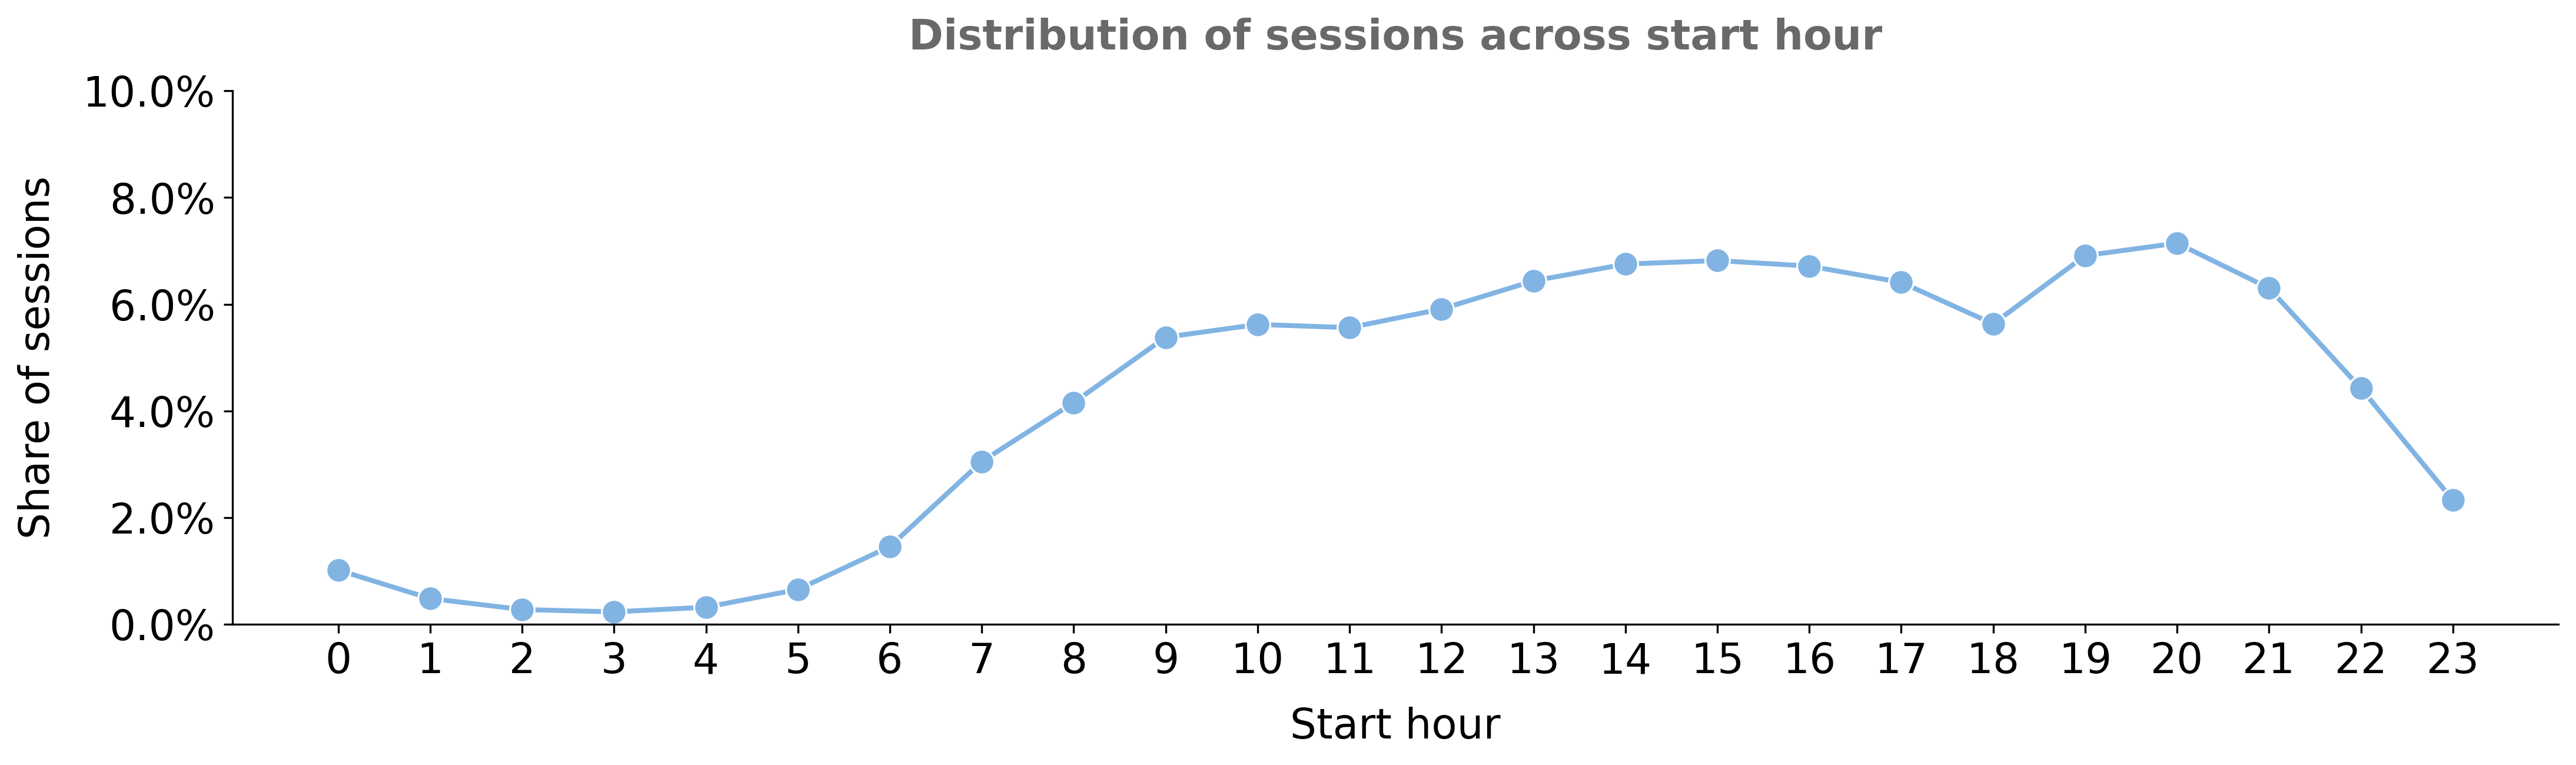

In [97]:
#Create the dataframe
df_start_hour = get_shares_single_col_df(time_related, 'start_hour')
df_start_hour = df_start_hour.reindex([18, 20, 22, 23, 21, 19, 17, 15, 14, 
                                       12, 10, 11, 8 , 5, 4, 2, 3, 6, 9,
                                      1, 0, 7, 13, 16]).reset_index(drop=True)

df_start_hour['share'] = df_start_hour['share']*100

#Creating plot architecture
fig = plt.figure(figsize = [17,4], dpi=300)

#Customize colors
colors = ["#81b4e3"]
customPalette = sns.set_palette(sns.color_palette(colors))

#Plotting graph
ax = sns.lineplot('cat', 'share', data = df_start_hour, palette = customPalette,
                          marker='o', linewidth = 2, ms = 10)

#Set aesthetic parameters
sns.set(style = 'white')
sns.despine()

#Set labels, title, legend, axis parameters
plt.xlabel('Start hour', fontsize = 17, labelpad = 10)
plt.ylabel('Share of sessions', fontsize = 17, labelpad = 10)
plt.title('Distribution of sessions across start hour', fontsize = 17, y = 1.05,
              color = "#696969",
              weight = "bold")
ax.tick_params(axis = 'both', which = 'major', labelsize = 17)
ax.set_ylim([0,10])

plt.yticks(np.arange(0,11, 2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(np.arange(0, 24, step=1)) 

plt.savefig('images/sessions_across_hour.png', bbox_inches='tight')



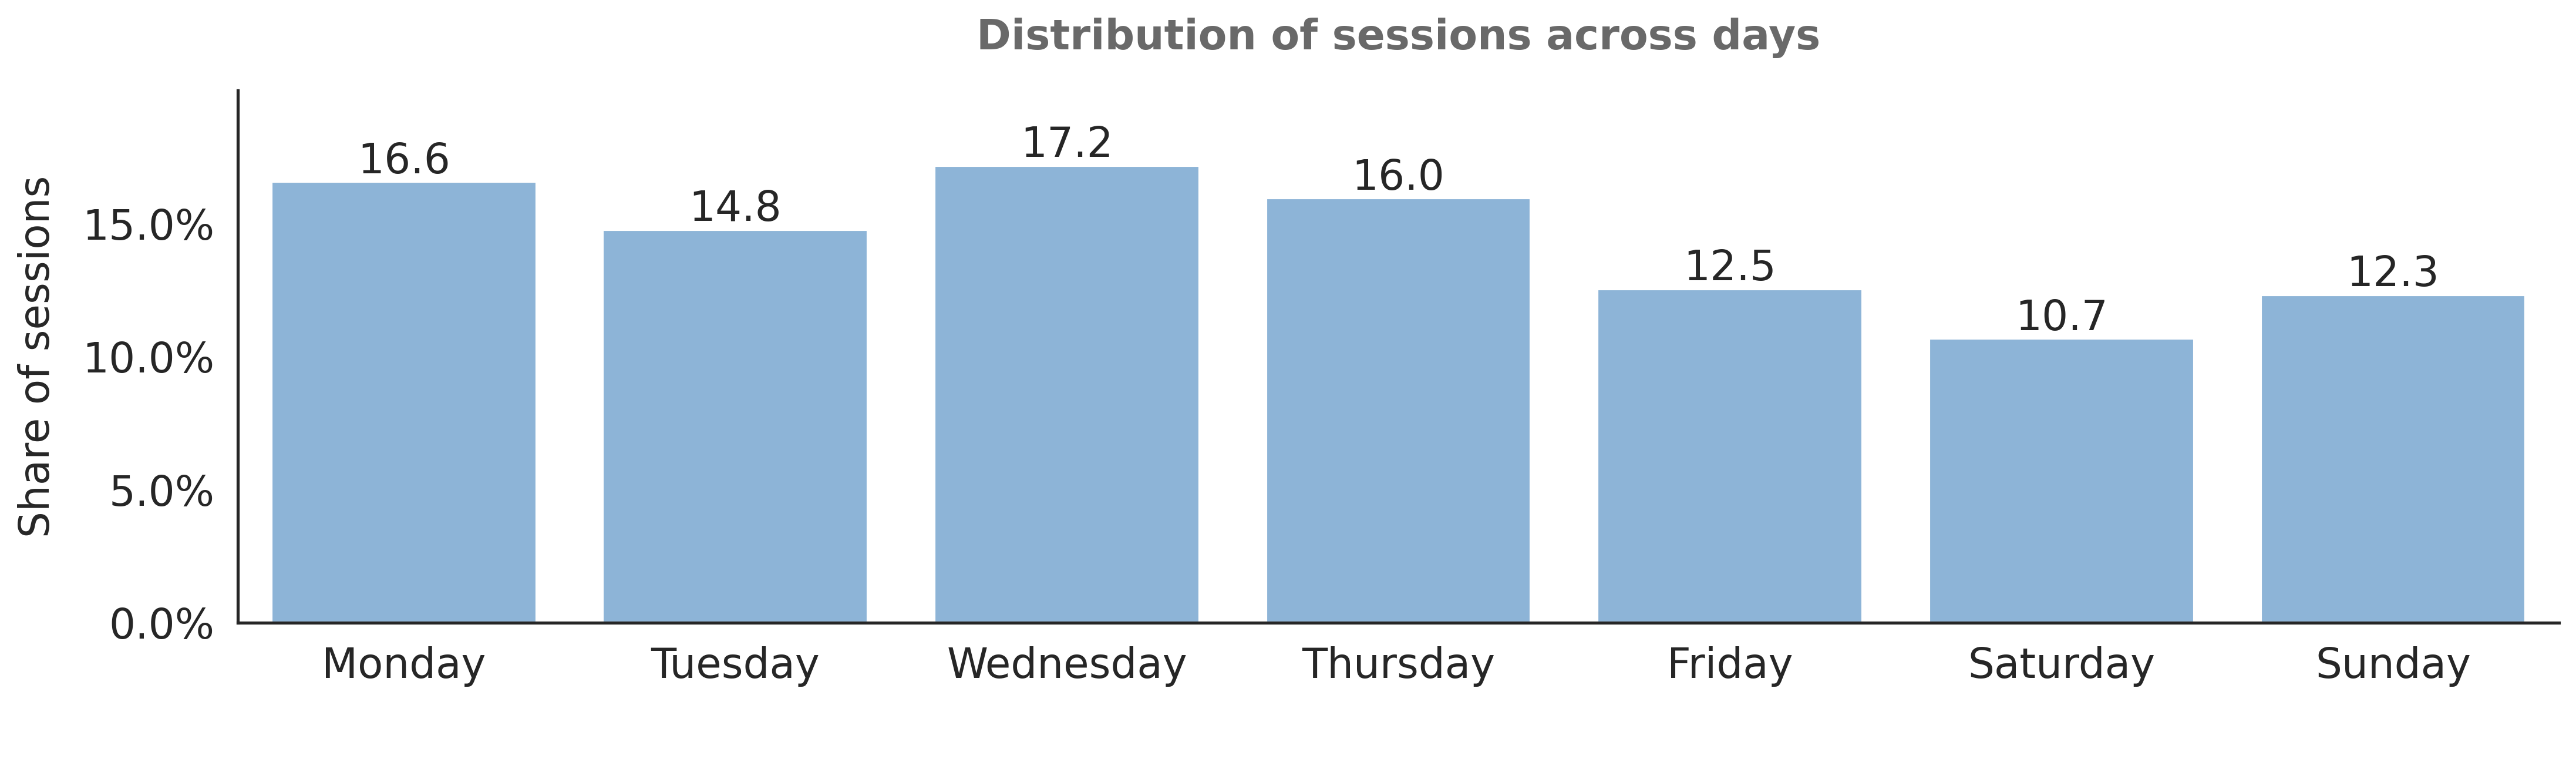

In [98]:
#Create dataframe 
df_day = get_shares_single_col_df(time_related, 'day')
df_day['share'] = df_day['share']*100

df_day = df_day.reindex([1,3,0,2,4,6,5]).reset_index(drop=True)
df_day.replace({'cat': {'0':'Monday', '1':'Tuesday','2':'Wednesday',
                       '3':'Thursday', '4':'Friday', '5':'Saturday', '6':'Sunday'}},inplace=True)


#Creating plot architecture
fig = plt.figure(figsize = [17, 4],dpi=300)

#Plotting graph
ax = sns.barplot(x = 'cat', y = 'share', data = df_day, color="#81b4e3")

#Set aesthetic parameters
sns.set(style = 'white')
sns.despine()

#Set labels, title, legend, axis parameters
plt.xlabel(' ', fontsize = 17, labelpad = 10)
plt.ylabel('Share of sessions',fontsize = 17, labelpad = 10)
plt.title('Distribution of sessions across days',
          fontsize = 17, 
          y = 1.05,
          color = "#696969",
          weight = "bold")
ax.tick_params(axis = 'both', which = 'major', labelsize = 17)
ax.set_ylim([0,20])
plt.yticks(np.arange(0,20, 5.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    #Add bar labels
for bars in ax.containers:
        ax.bar_label(bars, fmt = '%.1f',fontsize = 17)

plt.savefig('images/sessions_across_days.png', bbox_inches='tight')



In [99]:
device_traffic = df1[['interaction_id', 'device', 'traffic_source']].groupby('interaction_id').head(1).reset_index(drop=True)
print(device_traffic['interaction_id'].count())
print(device_traffic['interaction_id'].nunique())


device_traffic.head(3)

18378
18378


,interaction_id,device,traffic_source
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,Desktop,Other
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,Desktop,Search Engine
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,Desktop,Direct Traffic


In [100]:
entry = pd.merge(time_related, device_traffic, how='inner', on= 'interaction_id')
entry.head(3)

,interaction_id,start_hour,day,weekend,device,traffic_source
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,16,3,0,Desktop,Other
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,7,4,0,Desktop,Search Engine
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,13,3,0,Desktop,Direct Traffic


In [101]:
df_device = get_shares_single_col_df(entry, 'device')
df_traffic_source = get_shares_single_col_df(entry, 'traffic_source')

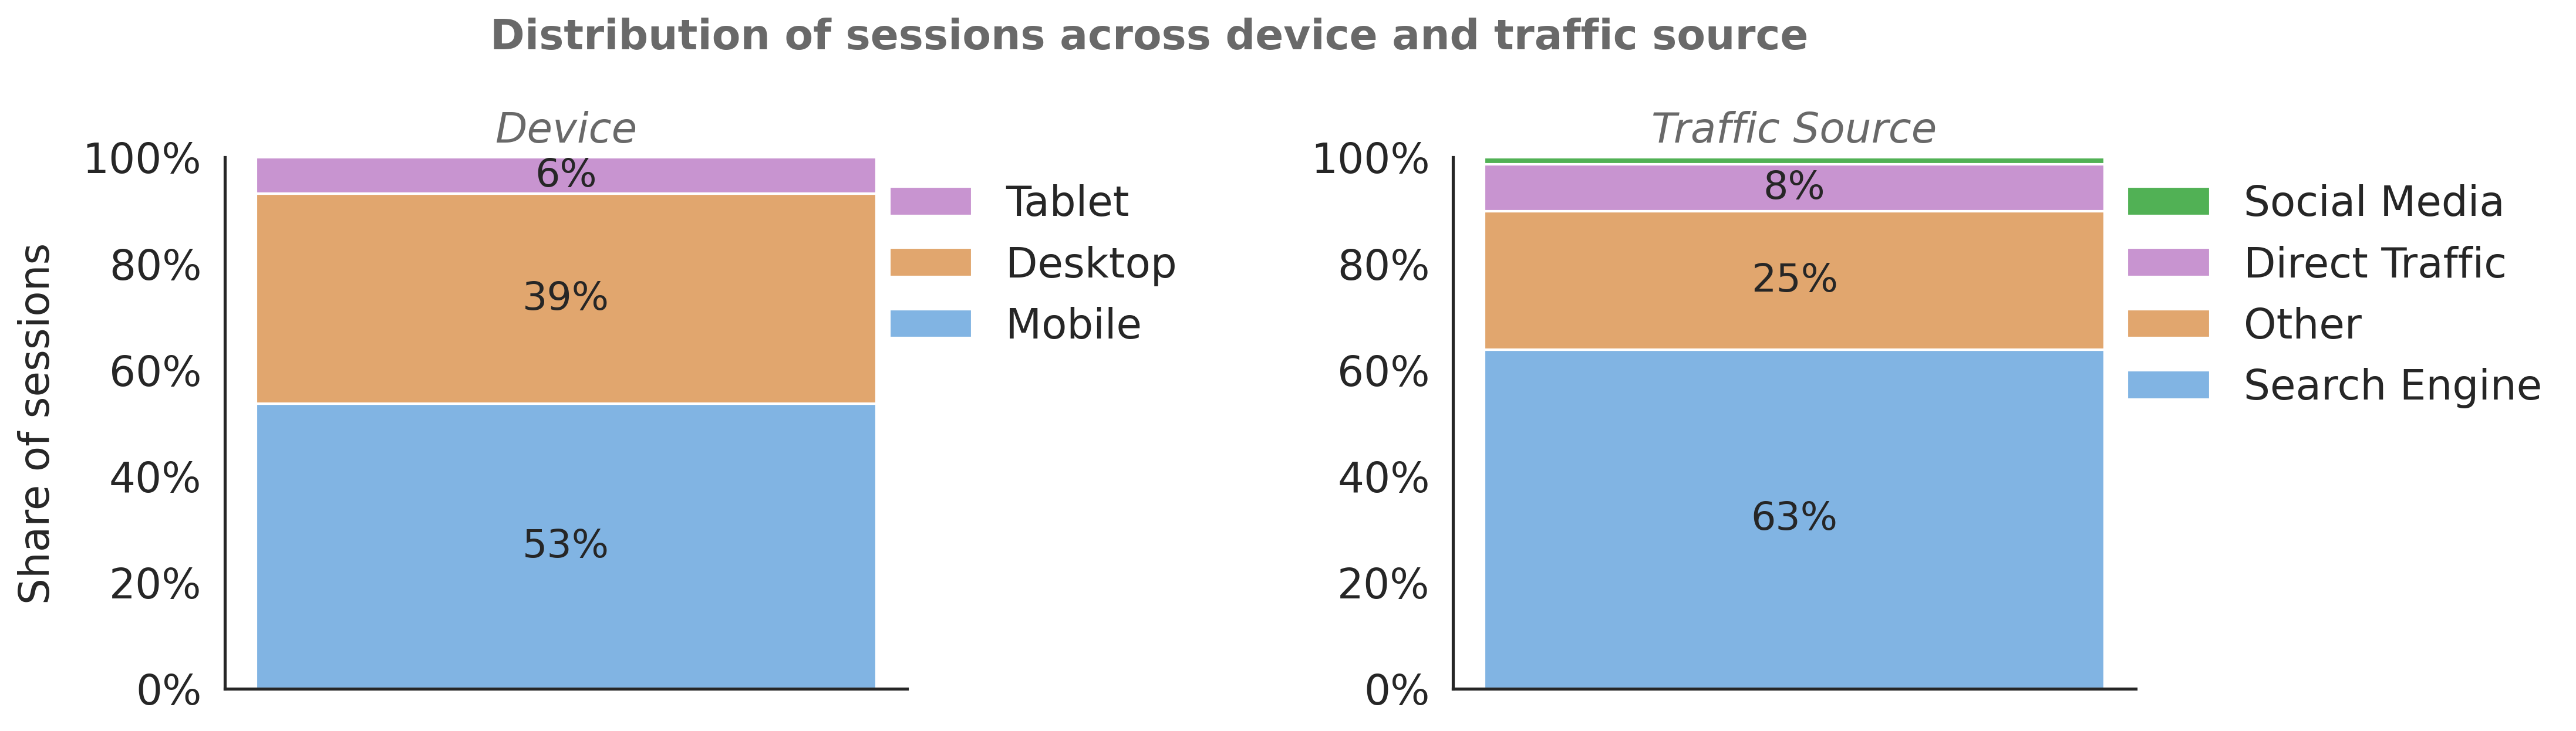

In [152]:
fig, ax = plt.subplots(figsize = (14, 4), ncols = 2, nrows = 1, dpi=300)
fig.subplots_adjust(hspace = 0.1, wspace=0.8)
sns.despine(top = True)
sns.set(style='white')
fig.suptitle('Distribution of sessions across device and traffic source', color = "#696969", va = "center", ha = "center",weight = "bold",
                     size = 17, y=1.05)

#Plotting for cluster 0
colors1 = ["#81b4e3", "#E1A66E", "#C894D0"]
bottom = 0
bars = []
for index, color in zip(range(len(df_device)), colors1):
    pct = df_device.loc[index, "share"]
    if pct > 0.04:
        ax[0].text(0, bottom + pct/2, "{}%".format(int(pct * 100)), va = "center", ha = "center",fontsize = 16 )
    category = df_device.loc[index, 'cat']
    bars.append(ax[0].bar(0, pct, width = 0.3, color = color, bottom = bottom))
    bottom += pct

#Plotting for cluster 1
colors2 = ["#81b4e3", "#E1A66E", "#C894D0", "#51B155"]
bottom = 0
bars2 = []
for index, color in zip(range(len(df_traffic_source)), colors2):
    pct = df_traffic_source.loc[index, "share"]
    if pct > 0.04:
        ax[1].text(0, bottom + pct/2, "{}%".format(int(pct*100)), va = "center", ha = "center",fontsize = 16)
    category = df_traffic_source.loc[index, 'cat']
    bars2.append(ax[1].bar(0, pct, width = 0.3, color = color, bottom = bottom))
    bottom += pct

#Setting parameters
axes = [ax[0], ax[1]]
for axis in axes:
    axis.axes.get_xaxis().set_visible(False)
    axis.set_ylim([0,1])
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax[0].set_title('Device', style = "italic", color = "#696969",fontsize = 17)
ax[1].set_title('Traffic Source', style = "italic", color = "#696969",fontsize = 17)
ax[0].set_ylabel('Share of sessions', fontsize = 17, labelpad = 10)
plt.rc('ytick', labelsize=17)

labels1 = ['Tablet','Desktop', 'Mobile']
ax[0].legend(handles=[bars[2],bars[1], bars[0]],labels=labels1,
                loc = "upper right", 
                bbox_to_anchor = (1.3,1.02,0.15,0),
                frameon = False,fontsize = 17)

labels2 = ['Social Media','Direct Traffic','Other','Search Engine']
ax[1].legend(handles=[bars2[3],bars2[2],bars2[1], bars2[0]],
                labels=labels2,
                loc = "upper right", 
                bbox_to_anchor = (1.5,1.02,0.15,0),
                frameon = False,fontsize = 17)


plt.savefig('images/sessions_across_device_traffic_source.png', bbox_inches='tight')


### General Features

In [153]:
total_pages  = df1[(df1['checkout']==0) &(df1['registration']==0)&(df1['cart_page']==0) ].groupby(['interaction_id'])['page_url_clean'].count().to_frame(name='pages_viewed').reset_index(drop=False)
print(total_pages['interaction_id'].count())
print(total_pages['interaction_id'].nunique())
total_pages.head(3)

18378
18378


,interaction_id,pages_viewed
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,2
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,2
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,4


In [154]:
total_duration = df1[(df1['checkout']==0) &(df1['registration']==0)&(df1['cart_page']==0) ].groupby('interaction_id')['page_duration'].sum().to_frame(name='session_duration').reset_index(drop=False)
print(total_duration['interaction_id'].count())
print(total_duration['interaction_id'].nunique())
total_duration.head(3)

18378
18378


,interaction_id,session_duration
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,43.522000
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,66.922000
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,208.541333


In [155]:
mean_page_duration = df1[(df1['checkout']==0) &(df1['registration']==0)&(df1['cart_page']==0) ].groupby('interaction_id')['page_duration'].mean().to_frame(name='avg_page_duration').reset_index(drop=False)
print(mean_page_duration['interaction_id'].count())
print(mean_page_duration['interaction_id'].nunique())
mean_page_duration.head(3)

18378
18378


,interaction_id,avg_page_duration
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,21.761000
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,33.461000
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,52.135333


In [156]:
general = pd.merge(pd.merge(total_pages, total_duration, how='left', on= 'interaction_id'), mean_page_duration, how='inner', on= 'interaction_id')
general.head(3)

,interaction_id,pages_viewed,session_duration,avg_page_duration
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,2,43.522000,21.761000
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,2,66.922000,33.461000
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,4,208.541333,52.135333


### Focus

In [157]:

df2 = df1[['interaction_id','page_url_clean','home', 'search', 'advice', 'information',
       'product', 'category', 'sale']].groupby('interaction_id').sum().reset_index(drop=False)

print(len(df2))

#Make a new df with the sum of unique pages that are info categorical search product home etc related
focus = pd.merge(df2, total_pages, how='left', on= 'interaction_id')

focus['home_pct'] = (focus['home']/focus['pages_viewed'])*100
focus['search_pct'] = (focus['search']/focus['pages_viewed'])*100
focus['advice_pct'] = (focus['advice']/focus['pages_viewed'])*100
focus['info_pct'] = (focus['information']/focus['pages_viewed'])*100
focus['product_pct'] = (focus['product']/focus['pages_viewed'])*100
focus['category_pct'] = (focus['category']/focus['pages_viewed'])*100
focus['sale_pct'] = (focus['sale']/focus['pages_viewed'])*100

focus = focus.drop(['home', 'search', 'advice', 'information',
       'product', 'category', 'sale','pages_viewed'],axis=1)
print(len(focus))
focus.head(3)

18378
18378


,interaction_id,home_pct,search_pct,advice_pct,info_pct,product_pct,category_pct,sale_pct
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,0.0,0.0,0.0,50.0,50.0,0.0,0.0
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,0.0,0.0,0.0,0.0,50.0,50.0,0.0
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,25.0,25.0,0.0,0.0,0.0,50.0,0.0


### Session Variety

In [158]:
# Group by session and drop duplicate URLs => keep only unique urls
df3 = df1[['interaction_id','page_url_clean','category', 'product']].drop_duplicates().groupby('interaction_id').sum().reset_index(drop=False)
print(len(df2))

#Rename the columns
df3.columns = ['interaction_id','unique_category_url', 'unique_product_url']


df4 = df1[['interaction_id','page_url_clean','category',
           'product']].groupby('interaction_id').sum().reset_index(drop=False)

print(len(df4))

#Make a new df with the sum of unique pages that are info categorical search product home etc related
variety = pd.merge(df3, df4, how='inner', on = 'interaction_id')

variety['unique_category_pct']  = (variety['unique_category_url']/variety['category']) *100
variety['unique_product_pct']  = (variety['unique_product_url']/variety['product']) *100


variety = variety.fillna(0)


variety = variety.drop(['category', 'product', 'unique_category_url', 
                        'unique_product_url'], axis=1)

print(variety['interaction_id'].count())
print(variety['interaction_id'].nunique())

variety.head(3)

18378
18378
18378
18378


,interaction_id,unique_category_pct,unique_product_pct
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,0.0,100.0
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,100.0,100.0
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,100.0,0.0


### Cart

In [159]:
cart = df1[['interaction_id', 'cart_value', 'cart_product_quantity']].groupby('interaction_id').tail(1).reset_index(drop=True)
cart['is_cart_empty'] = np.where(cart['cart_product_quantity'] == 0, 1, 0)

print(cart['interaction_id'].count())
print(cart['interaction_id'].nunique())

cart.head(3)

18378
18378


,interaction_id,cart_value,cart_product_quantity,is_cart_empty
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,0.0,0,1
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,0.0,0,1
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,0.0,0,1


### Visitor Information

In [160]:

visitor_information = df1[['interaction_id', 'user_id','is_logged_on', 'is_in_UK', 'previous_sessions', 'is_return_visitor']].groupby('interaction_id').head(1).reset_index(drop=True)

print(visitor_information['interaction_id'].count())
print(visitor_information['interaction_id'].nunique())

visitor_information.head(3)

18378
18378


,interaction_id,user_id,is_logged_on,is_in_UK,previous_sessions,is_return_visitor
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,12,0,1,0,0
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,16,0,1,0,0
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,89,0,0,0,0


### Purchase

In [161]:
purchase = df1[['interaction_id', 'is_purchase', 'revenue_generated']].groupby('interaction_id').tail(1).reset_index(drop=True)

print(purchase['interaction_id'].count())
print(purchase['interaction_id'].nunique())

purchase.head(3)

18378
18378


,interaction_id,is_purchase,revenue_generated
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,0.0,0.0
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,0.0,0.0
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,0.0,0.0


### Full df

In [162]:
full_df = pd.merge(pd.merge(entry, general, how='inner', on='interaction_id'),focus, how= 'inner', on='interaction_id')
full_df = pd.merge(full_df, variety, how='inner', on='interaction_id')

full_df = pd.merge(pd.merge(full_df, cart, how='inner', on='interaction_id'),visitor_information, how= 'inner', on='interaction_id')
full_df = pd.merge(full_df, purchase, how='inner', on='interaction_id')


print(full_df['interaction_id'].count())
print(full_df['interaction_id'].nunique()) 
full_df.head(3)

18378
18378


,interaction_id,start_hour,day,weekend,device,traffic_source,pages_viewed,session_duration,avg_page_duration,home_pct,search_pct,advice_pct,info_pct,product_pct,category_pct,sale_pct,unique_category_pct,unique_product_pct,cart_value,cart_product_quantity,is_cart_empty,user_id,is_logged_on,is_in_UK,previous_sessions,is_return_visitor,is_purchase,revenue_generated
0,00015d02-9839-4e38-b5cd-143d88f2c3eb,16,3,0,Desktop,Other,2,43.522000,21.761000,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,100.0,0.0,0,1,12,0,1,0,0,0.0,0.0
1,00024cbd-fd15-4ce0-a62d-9e8886a75414,7,4,0,Desktop,Search Engine,2,66.922000,33.461000,0.0,0.0,0.0,0.0,50.0,50.0,0.0,100.0,100.0,0.0,0,1,16,0,1,0,0,0.0,0.0
2,001023b1-a50a-4c92-b6d6-3073b66b52ca,13,3,0,Desktop,Direct Traffic,4,208.541333,52.135333,25.0,25.0,0.0,0.0,0.0,50.0,0.0,100.0,0.0,0.0,0,1,89,0,0,0,0,0.0,0.0


In [163]:
full_df.describe()

,start_hour,weekend,pages_viewed,session_duration,avg_page_duration,home_pct,search_pct,advice_pct,info_pct,product_pct,category_pct,sale_pct,unique_category_pct,unique_product_pct,cart_value,cart_product_quantity,is_cart_empty,user_id,is_logged_on,is_in_UK,previous_sessions,is_return_visitor,is_purchase,revenue_generated
count,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000,18378.000000
mean,14.620416,0.229894,2.876809,121.807678,44.839809,4.924915,9.384641,1.117208,3.687957,56.294877,24.590401,3.999192,40.990226,85.779964,27.013624,0.160083,0.872728,194817.591359,0.046197,0.975024,0.009740,0.006475,0.011209,1.221007
std,4.985259,0.420776,1.742639,99.903604,33.290031,13.232998,19.417262,7.299118,13.222330,34.491165,31.494451,14.199496,48.021637,34.121606,171.071020,0.480509,0.333286,114814.676527,0.209916,0.156055,0.142517,0.080209,0.105281,27.685802
min,0.000000,0.000000,1.000000,1.562000,1.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,2.000000,50.347500,21.081000,0.000000,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,1.000000,95648.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,0.000000,2.000000,94.274000,35.676500,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,1.000000,193723.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,0.000000,3.000000,166.044375,59.070750,0.000000,0.000000,0.000000,0.000000,100.000000,50.000000,0.000000,100.000000,100.000000,0.000000,0.000000,1.000000,293906.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,1.000000,30.000000,1340.119000,179.799000,80.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,6819.980000,6.000000,1.000000,396577.000000,1.000000,1.000000,7.000000,1.000000,1.000000,2310.000000


In [164]:
## Find the threshold of values that are ±3 std from the mean
print(full_df['pages_viewed'].mean() + 3 * full_df['pages_viewed'].std())
print(full_df['pages_viewed'].mean() - 3 * full_df['pages_viewed'].std())

print(full_df['session_duration'].mean() + 3 * full_df['session_duration'].std())
print(full_df['session_duration'].mean() - 3 * full_df['session_duration'].std())

print(full_df['avg_page_duration'].mean() + 3 * full_df['avg_page_duration'].std())
print(full_df['avg_page_duration'].mean() - 3 * full_df['avg_page_duration'].std())


8.104725932747753
-2.351107475897171
421.5184909282735
-177.90313555722838
144.7099026804632
-55.03028424726289


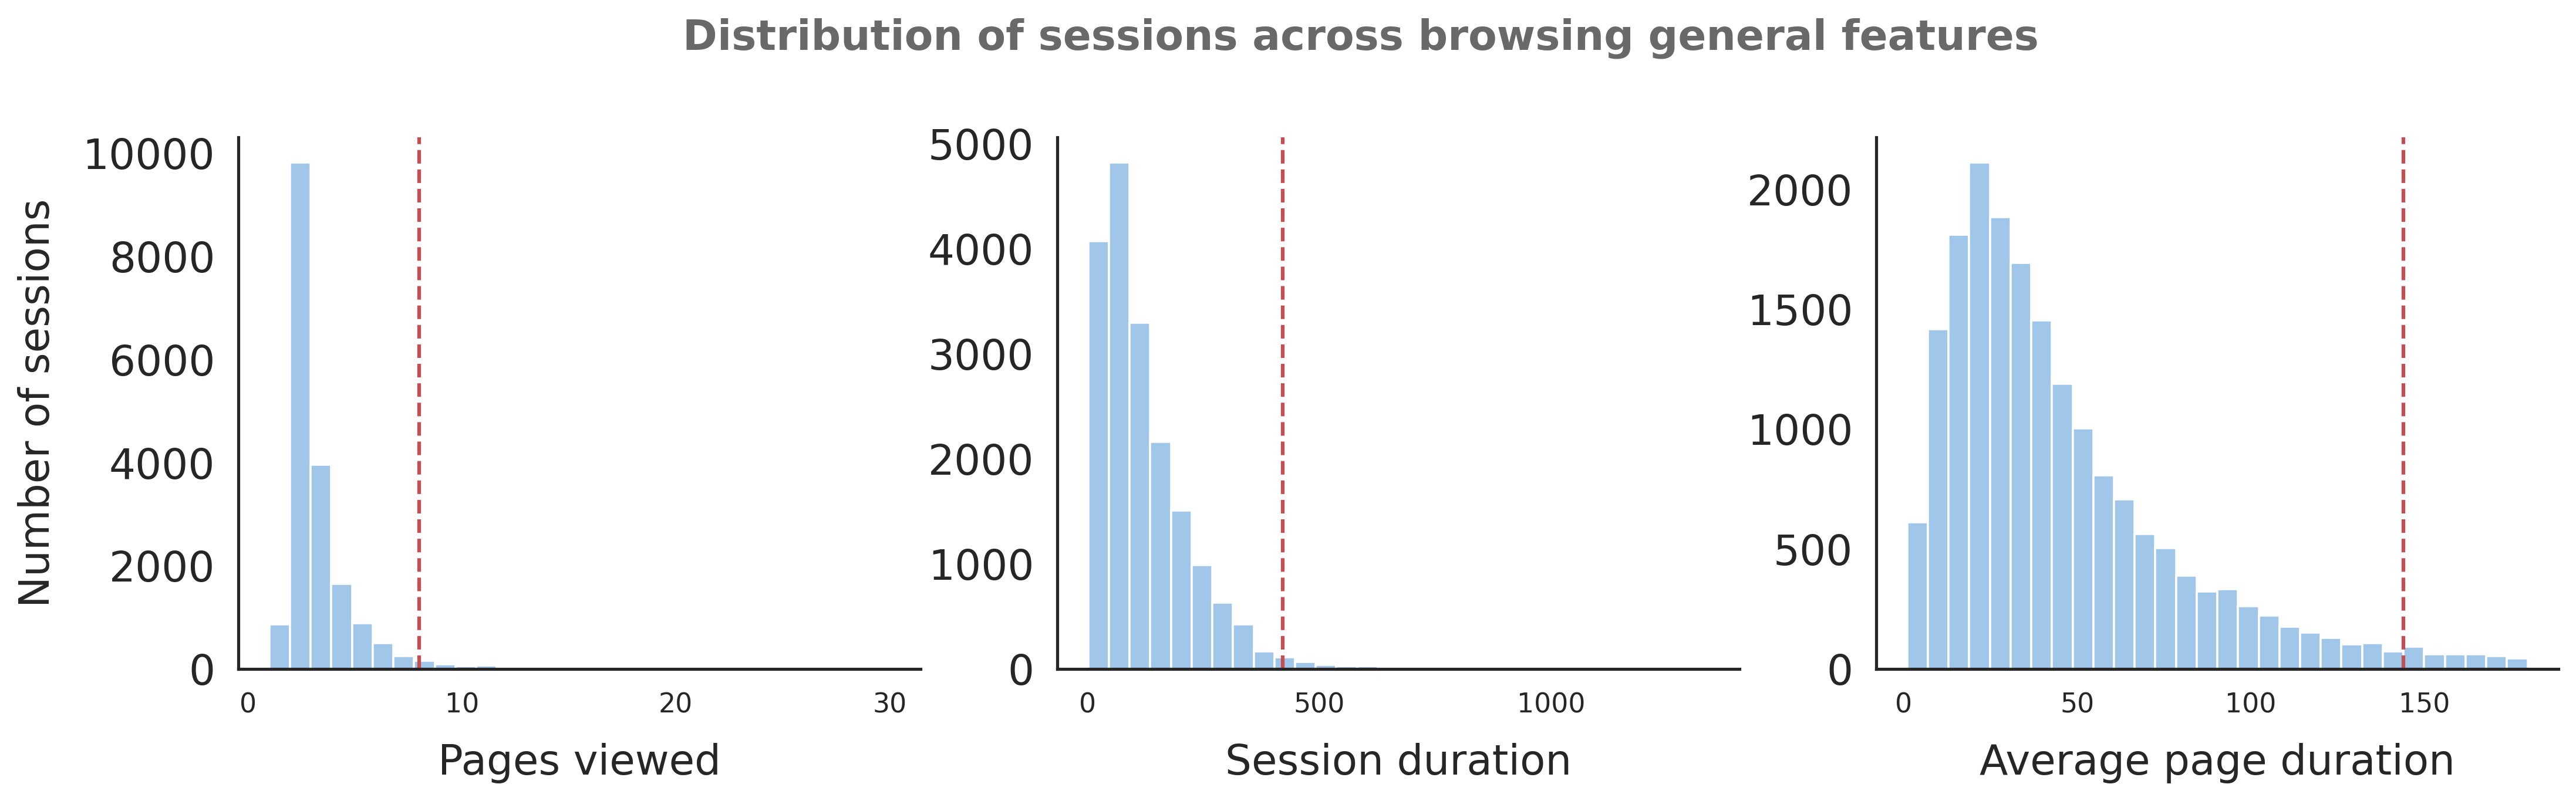

In [165]:
#Preparing data

#Creating plot architecture
plt.subplots(figsize = (17,4), ncols = 3, nrows = 1, dpi=300)
plt.subplots_adjust(hspace = 1.4, wspace=0.2)
sns.despine(top = True)
plt.suptitle("Distribution of sessions across browsing general features",
             color = "#696969",
             weight = "bold",
             size = 17, y=1.05)

plt.subplot(1,3, 1) 
sns.histplot( full_df["pages_viewed"],bins=30,color="#81b4e3");
sns.set(style = 'white')
sns.despine()
plt.ylabel('Number of sessions',fontsize = 17, labelpad=10) 
plt.rc('xtick', labelsize=17)    
plt.rc('ytick', labelsize=17)
plt.axvline(x=8, color='r', linestyle='--')
plt.xlabel('Pages viewed' ,fontsize = 17,labelpad=10);

plt.subplot(1,3, 2) 
sns.histplot( full_df["session_duration"],bins=30,color="#81b4e3");
sns.set(style = 'white')
sns.despine()
plt.ylabel('', labelpad=10)
plt.rc('xtick', labelsize=17)    
plt.rc('ytick', labelsize=17)
plt.axvline(x=421, color='r', linestyle='--')
plt.xlabel('Session duration' ,fontsize = 17,labelpad=10);

plt.subplot(1,3, 3)
sns.histplot( full_df["avg_page_duration"],bins=30,color="#81b4e3");
sns.set(style = 'white')
sns.despine()
plt.ylabel('', labelpad=10) 
plt.axvline(x=144, color='r', linestyle='--')
plt.rc('xtick', labelsize=17)    
plt.rc('ytick', labelsize=17)
plt.xlabel('Average page duration' ,fontsize = 17,labelpad=10);
plt.savefig('images/histogram.png', bbox_inches='tight')



### Remove Outliers in  numerical columns

Similar to Zavalli, exclude data points with values that exceeded the mean by ± 3 standard deviations 

In [166]:
pages_viewed_outliers = [x for x in full_df['pages_viewed'] if (x > full_df['pages_viewed'].mean() + 3 * full_df['pages_viewed'].std()) or
                        (x < full_df['pages_viewed'].mean() - 3 * full_df['pages_viewed'].std())]

session_duration_outliers = [x for x in full_df['session_duration'] if (x > full_df['session_duration'].mean() + 3 * full_df['session_duration'].std()) or
                        (x < full_df['session_duration'].mean() - 3 * full_df['session_duration'].std())]

avg_page_duration_outliers = [x for x in full_df['avg_page_duration'] if (x > full_df['avg_page_duration'].mean() + 3 * full_df['avg_page_duration'].std()) or
                        (x < full_df['avg_page_duration'].mean() - 3 * full_df['avg_page_duration'].std())]


In [167]:
full_df = full_df[~full_df['pages_viewed'].isin(pages_viewed_outliers)]
full_df = full_df[~full_df['session_duration'].isin(session_duration_outliers)]
full_df = full_df[~full_df['avg_page_duration'].isin(avg_page_duration_outliers)]


In [168]:
full_df.describe()

,start_hour,weekend,pages_viewed,session_duration,avg_page_duration,home_pct,search_pct,advice_pct,info_pct,product_pct,category_pct,sale_pct,unique_category_pct,unique_product_pct,cart_value,cart_product_quantity,is_cart_empty,user_id,is_logged_on,is_in_UK,previous_sessions,is_return_visitor,is_purchase,revenue_generated
count,17604.000000,17604.000000,17604.00000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.00000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000,17604.000000
mean,14.607760,0.230402,2.72813,110.515243,42.364858,5.048359,9.462345,1.098235,3.729266,56.521455,24.140340,4.00653,40.494138,85.553797,26.783030,0.155817,0.875653,194770.697626,0.045160,0.974949,0.009998,0.006589,0.010736,1.139510
std,4.986835,0.421102,1.25540,79.907342,29.326449,13.436812,19.548131,7.263956,13.335162,34.515438,31.392868,14.25606,48.122899,34.434768,172.502148,0.473438,0.329986,114700.423605,0.207661,0.156285,0.145027,0.080910,0.103061,26.778569
min,0.000000,0.000000,1.00000,1.562000,1.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,2.00000,48.814500,20.615125,0.000000,0.000000,0.000000,0.000000,33.333333,0.000000,0.00000,0.000000,100.000000,0.000000,0.000000,1.000000,95672.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,0.000000,2.00000,89.857000,34.789700,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.00000,0.000000,100.000000,0.000000,0.000000,1.000000,193710.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,0.000000,3.00000,154.128750,56.862000,0.000000,0.000000,0.000000,0.000000,100.000000,50.000000,0.00000,100.000000,100.000000,0.000000,0.000000,1.000000,293580.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,1.000000,8.00000,421.081143,144.659000,80.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,6819.980000,6.000000,1.000000,396577.000000,1.000000,1.000000,7.000000,1.000000,1.000000,2310.000000


In [169]:
print("After removing sessions with pages views, session duration, and avg page duration ± 3 std from the mean, the length of the dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(len(full_df)) + " unique sessions")
print("It contains: " + str(full_df[full_df['is_purchase']==1]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (full_df[full_df['is_purchase']==1]['interaction_id'].nunique()/full_df.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')
print("It contains: " + str(full_df.user_id.nunique()) + " unique visitors")


After removing sessions with pages views, session duration, and avg page duration ± 3 std from the mean, the length of the dataset is: 56097 observations
It contains: 17604 unique sessions
It contains: 189 sessions that end in purchase
The conversion rate is: 1.074 %
It contains: 17585 unique visitors


## User-level Dataset

In [170]:
full_df = full_df.sort_values(['user_id','previous_sessions'],ascending=True)

In [171]:
full_df = full_df.drop_duplicates(subset=['user_id'], keep='last')
full_df.describe()

,start_hour,weekend,pages_viewed,session_duration,avg_page_duration,home_pct,search_pct,advice_pct,info_pct,product_pct,category_pct,sale_pct,unique_category_pct,unique_product_pct,cart_value,cart_product_quantity,is_cart_empty,user_id,is_logged_on,is_in_UK,previous_sessions,is_return_visitor,is_purchase,revenue_generated
count,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000
mean,14.609326,0.230253,2.728234,110.530031,42.364791,5.028697,9.460721,1.098474,3.724765,56.538927,24.148415,4.004224,40.492397,85.580839,26.715727,0.155303,0.876031,194876.651066,0.044129,0.974922,0.008871,0.005914,0.010748,1.140742
std,4.987143,0.421007,1.255113,79.908214,29.317461,13.401723,19.548517,7.266846,13.330563,34.508331,31.401442,14.254492,48.121502,34.408102,172.510863,0.472688,0.329556,114686.043310,0.205386,0.156367,0.137121,0.076678,0.103116,26.793006
min,0.000000,0.000000,1.000000,1.562000,1.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,2.000000,48.826000,20.621500,0.000000,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,1.000000,95894.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,0.000000,2.000000,89.932000,34.788400,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,1.000000,193848.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,0.000000,3.000000,154.106000,56.866500,0.000000,0.000000,0.000000,0.000000,100.000000,50.000000,0.000000,100.000000,100.000000,0.000000,0.000000,1.000000,293712.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,1.000000,8.000000,421.081143,144.659000,80.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,6819.980000,6.000000,1.000000,396577.000000,1.000000,1.000000,7.000000,1.000000,1.000000,2310.000000


In [172]:
print("The length of the visitor-level dataset is: " + str(len(df1)) + " observations")
print("It contains: " + str(len(full_df)) + " unique sessions")
print("It contains: " + str(full_df[full_df['is_purchase']==1]['interaction_id'].nunique()) + " sessions that end in purchase")
conversion_rate = (full_df[full_df['is_purchase']==1]['interaction_id'].nunique()/full_df.interaction_id.nunique())*100
print("The conversion rate is: " + str(round(conversion_rate, 3)) + ' %')
print("It contains: " + str(full_df.user_id.nunique()) + " unique visitors")
print("It contains: " + str(len(full_df[full_df['is_return_visitor']==1])) + " return visitors")
print("It contains: " + str(len(full_df[full_df['is_logged_on']==1])) + " logged on visitors")
print("It contains: " + str(len(full_df[full_df['is_in_UK']==1])) + " visitors in UK")


The length of the visitor-level dataset is: 56097 observations
It contains: 17585 unique sessions
It contains: 189 sessions that end in purchase
The conversion rate is: 1.075 %
It contains: 17585 unique visitors
It contains: 104 return visitors
It contains: 776 logged on visitors
It contains: 17144 visitors in UK


In [173]:
# Drop column no longer needed
full_df = full_df.drop(['user_id'], axis=1)

In [126]:
full_df.to_csv("resulting_dataset.csv")

## Statistics

In [26]:
full_df = pd.read_csv("resulting_dataset.csv")


### Range, stdev, mean

In [27]:
full_df.describe()


,Unnamed: 0,start_hour,day,weekend,pages_viewed,session_duration,avg_page_duration,home_pct,search_pct,advice_pct,info_pct,product_pct,category_pct,sale_pct,unique_category_pct,unique_product_pct,cart_value,cart_product_quantity,is_cart_empty,is_logged_on,is_in_UK,previous_sessions,is_return_visitor,is_purchase,revenue_generated
count,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000,17585.000000
mean,9191.359283,14.609326,2.742622,0.230253,2.728234,110.530031,42.364791,5.028697,9.460721,1.098474,3.724765,56.538927,24.148415,4.004224,40.492397,85.580839,26.715727,0.155303,0.876031,0.044129,0.974922,0.008871,0.005914,0.010748,1.140742
std,5299.477672,4.987143,1.964296,0.421007,1.255113,79.908214,29.317461,13.401723,19.548517,7.266846,13.330563,34.508331,31.401442,14.254492,48.121502,34.408102,172.510863,0.472688,0.329556,0.205386,0.156367,0.137121,0.076678,0.103116,26.793006
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.562000,1.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4604.000000,11.000000,1.000000,0.000000,2.000000,48.826000,20.621500,0.000000,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9194.000000,15.000000,3.000000,0.000000,2.000000,89.932000,34.788400,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,13775.000000,19.000000,4.000000,0.000000,3.000000,154.106000,56.866500,0.000000,0.000000,0.000000,0.000000,100.000000,50.000000,0.000000,100.000000,100.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,18377.000000,23.000000,6.000000,1.000000,8.000000,421.081143,144.659000,80.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,6819.980000,6.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,2310.000000


In [31]:
full_df[full_df['is_cart_empty']==0]['is_purchase'].value_counts()

0.0    1991
1.0    189 
Name: is_purchase, dtype: int64

### Median

In [7]:
columns = ['pages_viewed', 'session_duration','avg_page_duration', 
           'home_pct', 'search_pct', 'advice_pct', 'info_pct',
       'product_pct', 'category_pct', 'sale_pct', 'unique_category_pct',
       'unique_product_pct', 'cart_value', 'cart_product_quantity', 'previous_sessions',
       'revenue_generated']

In [8]:
for col in columns:
    print(col)
    print(full_df[col].median())

pages_viewed
2.0
session_duration
89.932
avg_page_duration
34.7884
home_pct
0.0
search_pct
0.0
advice_pct
0.0
info_pct
0.0
product_pct
50.0
category_pct
0.0
sale_pct
0.0
unique_category_pct
0.0
unique_product_pct
100.0
cart_value
0.0
cart_product_quantity
0.0
previous_sessions
0.0
revenue_generated
0.0


### Skew

In [9]:
full_df.skew(axis = 0, skipna = True)

Unnamed: 0              -0.000817 
start_hour              -0.395045 
day                      0.193874 
weekend                  1.281583 
pages_viewed             1.704627 
session_duration         1.084658 
avg_page_duration        1.136096 
home_pct                 2.578117 
search_pct               1.931363 
advice_pct               7.324919 
info_pct                 3.661870 
product_pct             -0.073178 
category_pct             0.901162 
sale_pct                 4.060381 
unique_category_pct      0.376394 
unique_product_pct      -2.037043 
cart_value               16.362632
cart_product_quantity    4.275167 
is_cart_empty           -2.282305 
is_logged_on             4.439663 
is_in_UK                -6.075138 
previous_sessions        22.837146
is_return_visitor        12.888787
is_purchase              9.490446 
revenue_generated        58.269743
dtype: float64

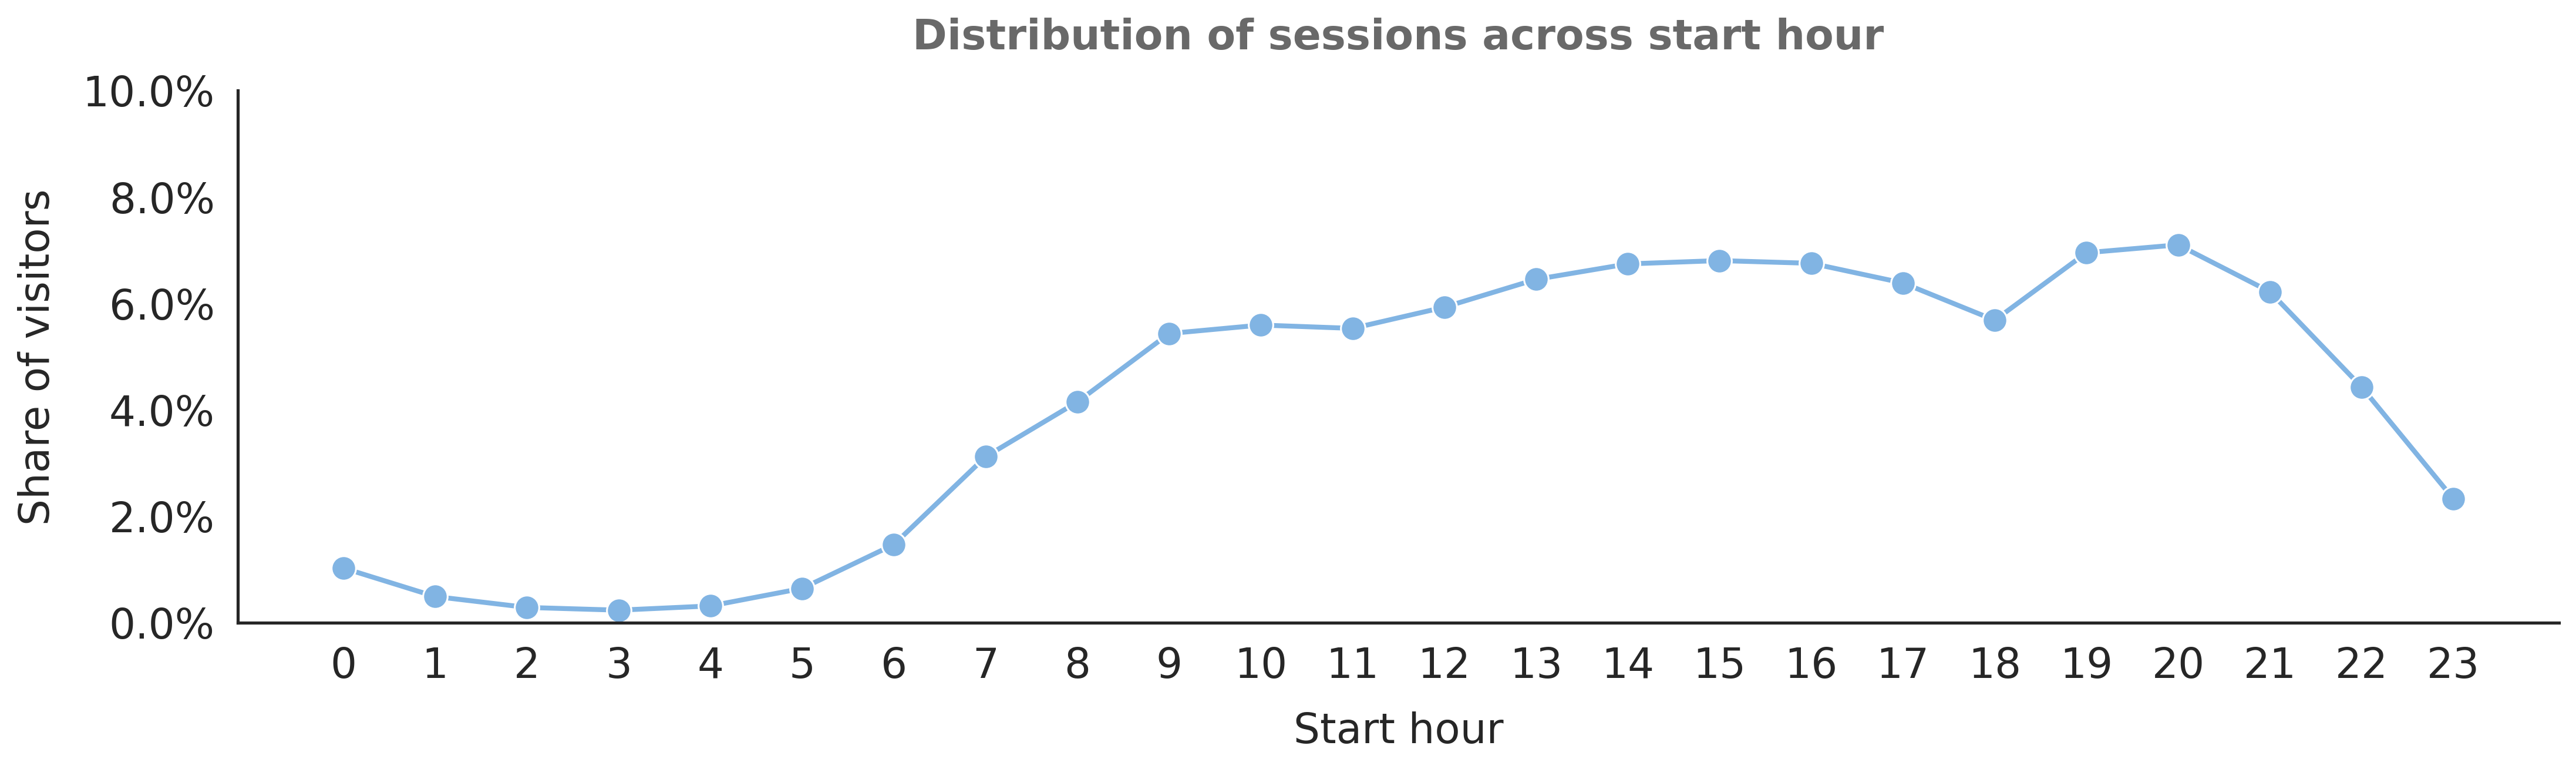

In [14]:
#Create the dataframe
df_start_hour = get_shares_single_col_df(full_df, 'start_hour')
df_start_hour = df_start_hour.reindex([18, 20, 22, 23, 21, 19, 17, 15, 14, 
                                       12, 10, 11, 8 , 5, 4, 2, 3, 6, 9,
                                      1, 0, 7, 13, 16]).reset_index(drop=True)

df_start_hour['share'] = df_start_hour['share']*100

#Creating plot architecture
fig = plt.figure(figsize = [17,4], dpi=300)

#Customize colors
colors = ["#81b4e3"]
customPalette = sns.set_palette(sns.color_palette(colors))

#Plotting graph
ax = sns.lineplot('cat', 'share', data = df_start_hour, palette = customPalette,
                          marker='o', linewidth = 2, ms = 10)

#Set aesthetic parameters
sns.set(style = 'white')
sns.despine()

#Set labels, title, legend, axis parameters
plt.xlabel('Start hour', fontsize = 17, labelpad = 10)
plt.ylabel('Share of visitors', fontsize = 17, labelpad = 10)
plt.title('Distribution of sessions across start hour', fontsize = 17, y = 1.05,
              color = "#696969",
              weight = "bold")
ax.tick_params(axis = 'both', which = 'major', labelsize = 17)
ax.set_ylim([0,10])

plt.yticks(np.arange(0,11, 2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(np.arange(0, 24, step=1)) 

plt.savefig('images/visitors_across_hour.png', bbox_inches='tight')



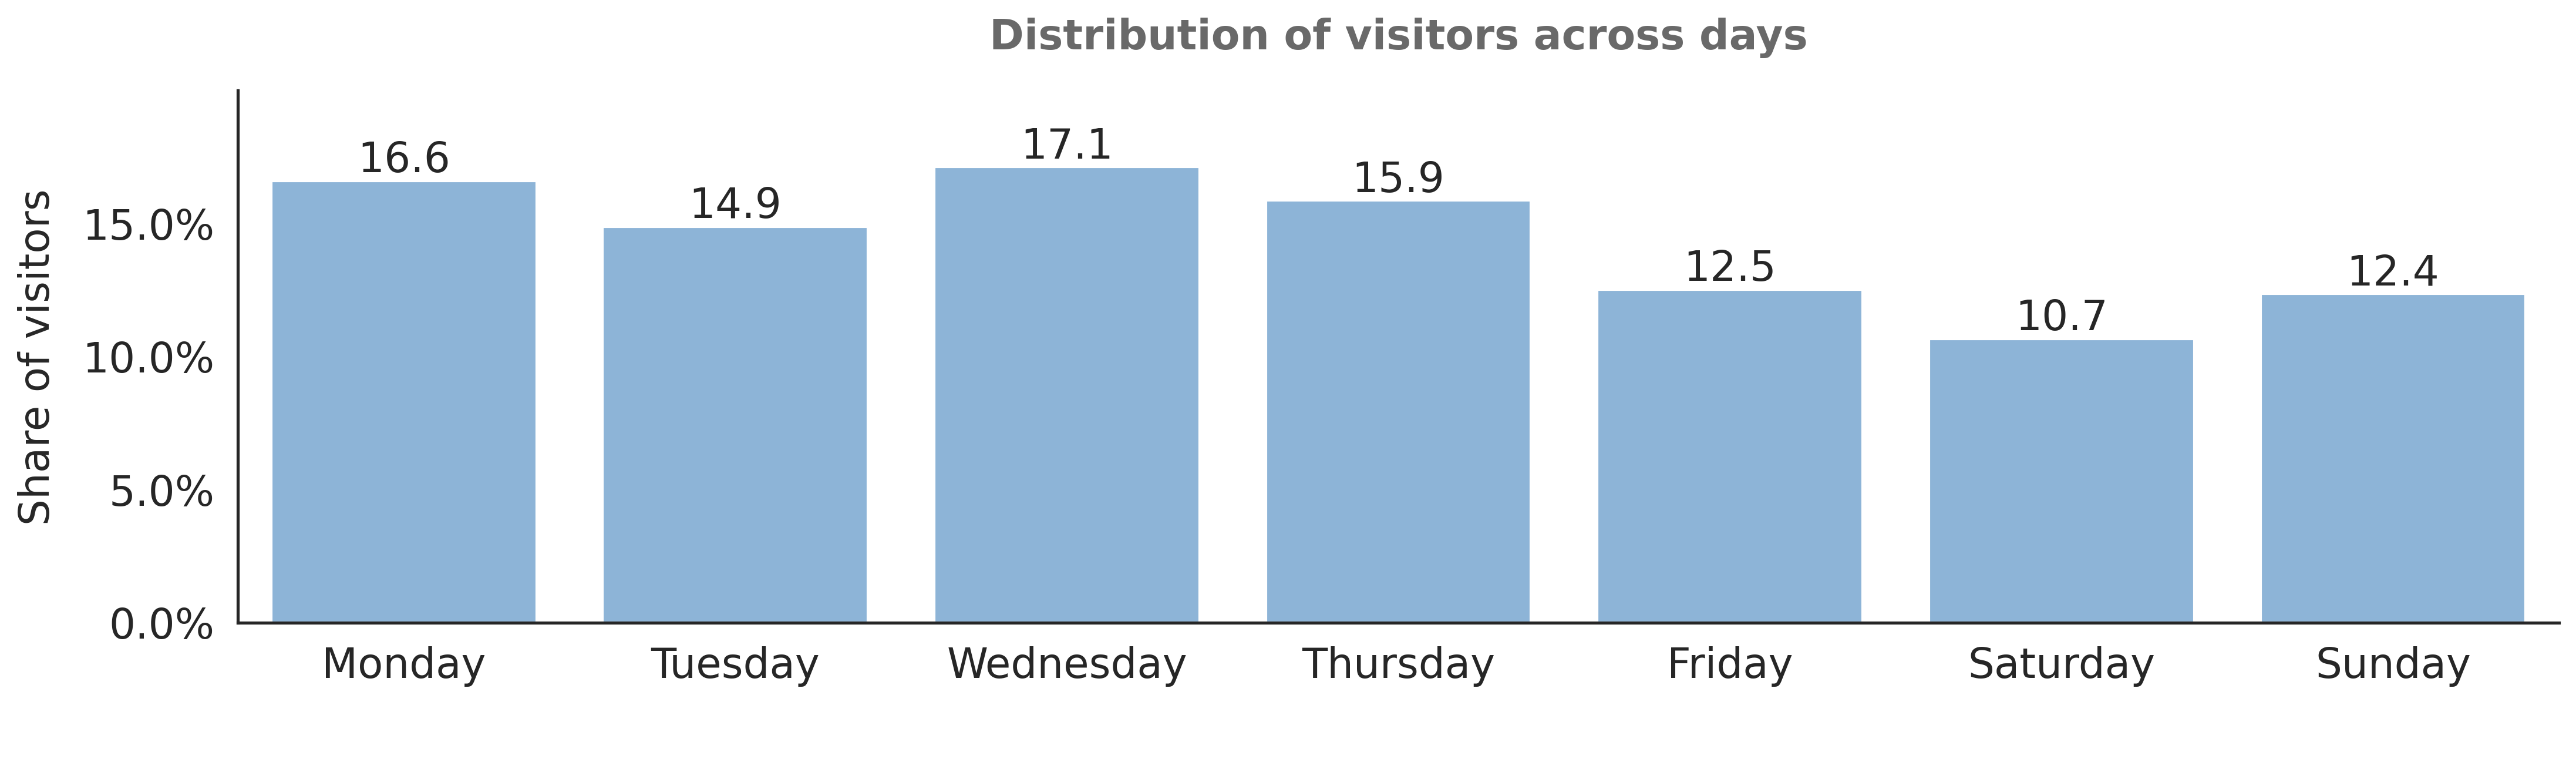

In [24]:
#Create dataframe 
df_day = get_shares_single_col_df(full_df, 'day')
df_day['share'] = df_day['share']*100

df_day.replace({'cat': {0:'Monday', 1:'Tuesday',2:'Wednesday',
                       3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}},inplace=True)


df_day = df_day.reindex([1,3,0,2,4,6,5]).reset_index(drop=True)
df_day.replace({'cat': {'0':'Monday', '1':'Tuesday','2':'Wednesday',
                       '3':'Thursday', '4':'Friday', '5':'Saturday', '6':'Sunday'}},inplace=True)


#Creating plot architecture
fig = plt.figure(figsize = [17, 4],dpi=300)

#Plotting graph
ax = sns.barplot(x = 'cat', y = 'share', data = df_day, color="#81b4e3")

#Set aesthetic parameters
sns.set(style = 'white')
sns.despine()

#Set labels, title, legend, axis parameters
plt.xlabel(' ', fontsize = 17, labelpad = 10)
plt.ylabel('Share of visitors',fontsize = 17, labelpad = 10)
plt.title('Distribution of visitors across days',
          fontsize = 17, 
          y = 1.05,
          color = "#696969",
          weight = "bold")
ax.tick_params(axis = 'both', which = 'major', labelsize = 17)
ax.set_ylim([0,20])
plt.yticks(np.arange(0,20, 5.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    #Add bar labels
for bars in ax.containers:
        ax.bar_label(bars, fmt = '%.1f',fontsize = 17)

plt.savefig('images/visitors_across_days.png', bbox_inches='tight')


In [10]:
df_device = get_shares_single_col_df(full_df, 'device')
df_traffic_source = get_shares_single_col_df(full_df, 'traffic_source')

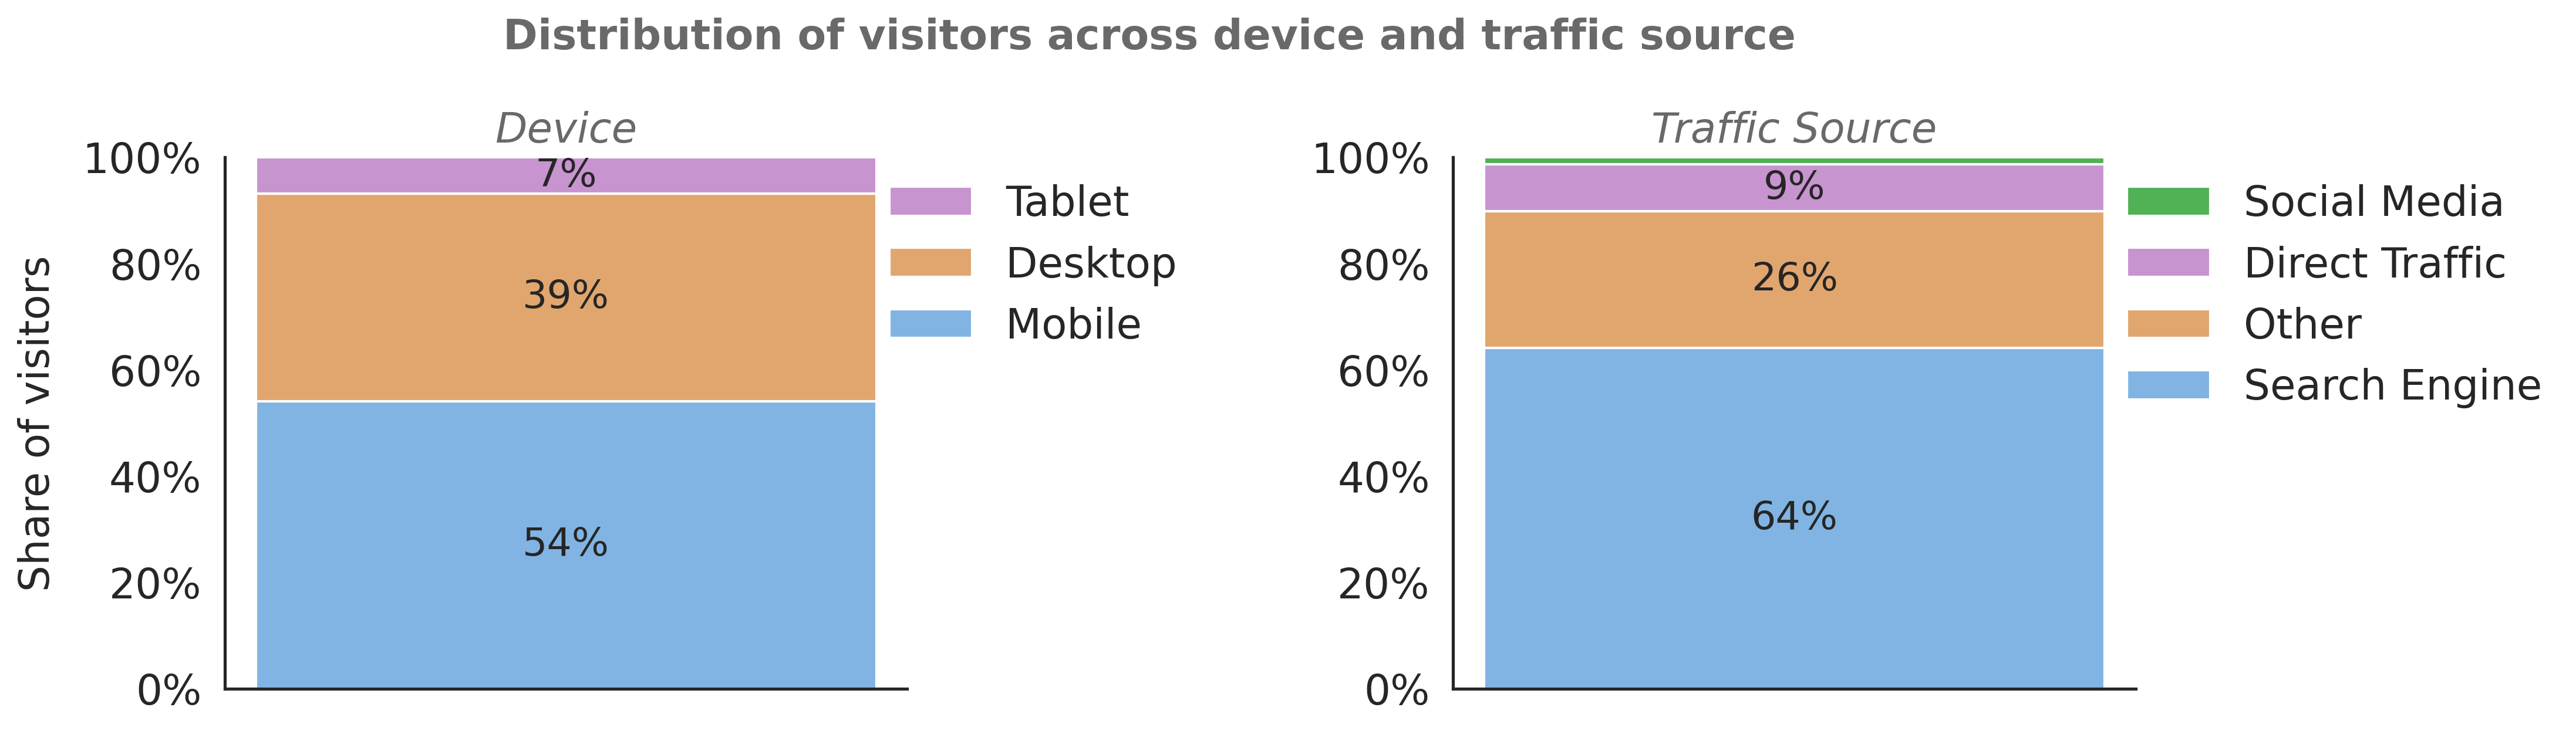

In [23]:
fig, ax = plt.subplots(figsize = (14, 4), ncols = 2, nrows = 1, dpi=300)
fig.subplots_adjust(hspace = 0.1, wspace=0.8)
sns.despine(top = True)
sns.set(style='white')
fig.suptitle('Distribution of visitors across device and traffic source', color = "#696969", va = "center", ha = "center",weight = "bold",
                     size = 17, y=1.05)

#Plotting for cluster 0
colors1 = ["#81b4e3", "#E1A66E", "#C894D0"]
bottom = 0
bars = []
for index, color in zip(range(len(df_device)), colors1):
    pct = df_device.loc[index, "share"]
    if pct > 0.04:
        ax[0].text(0, bottom + pct/2, "{}%".format(int(round((pct*100),0))), va = "center", ha = "center",fontsize = 16 )
    category = df_device.loc[index, 'cat']
    bars.append(ax[0].bar(0, pct, width = 0.3, color = color, bottom = bottom))
    bottom += pct

#Plotting for cluster 1
colors2 = ["#81b4e3", "#E1A66E", "#C894D0", "#51B155"]
bottom = 0
bars2 = []
for index, color in zip(range(len(df_traffic_source)), colors2):
    pct = df_traffic_source.loc[index, "share"]
    if pct > 0.04:
        ax[1].text(0, bottom + pct/2, "{}%".format(int(round((pct*100),0))), va = "center", ha = "center",fontsize = 16)
    category = df_traffic_source.loc[index, 'cat']
    bars2.append(ax[1].bar(0, pct, width = 0.3, color = color, bottom = bottom))
    bottom += pct

#Setting parameters
axes = [ax[0], ax[1]]
for axis in axes:
    axis.axes.get_xaxis().set_visible(False)
    axis.set_ylim([0,1])
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax[0].set_title('Device', style = "italic", color = "#696969",fontsize = 17)
ax[1].set_title('Traffic Source', style = "italic", color = "#696969",fontsize = 17)
ax[0].set_ylabel('Share of visitors', fontsize = 17, labelpad = 10)
plt.rc('ytick', labelsize=17)

labels1 = ['Tablet','Desktop', 'Mobile']
ax[0].legend(handles=[bars[2],bars[1], bars[0]],labels=labels1,
                loc = "upper right", 
                bbox_to_anchor = (1.3,1.02,0.15,0),
                frameon = False,fontsize = 17)

labels2 = ['Social Media','Direct Traffic','Other','Search Engine']
ax[1].legend(handles=[bars2[3],bars2[2],bars2[1], bars2[0]],
                labels=labels2,
                loc = "upper right", 
                bbox_to_anchor = (1.5,1.02,0.15,0),
                frameon = False,fontsize = 17)


plt.savefig('images/visitors_across_device_traffic_source.png', bbox_inches='tight')
